In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def shifted_exp(s, rate):
    return lambda: np.random.exponential(scale=rate) + s

In [6]:
# def ADSAGA_iteration(xs, H, delays, Alphas, Abar, eta, delay_dist, grad):
#     n = len(Alphas)
#     m = len(H)
#     assert int(n/m)*m == n # assert that m divides n
    
#     # Find machine which is next to update
#     j = np.argmin(delays)
    
#     # Perform stale SAGA update and update Abar
#     x = np.copy(xs[-1])
#     x_new = x - eta*(H[j] + Abar)
#     Abar += (H[j]/n)
#     xs.append(x_new)
       
#     # Update delay variables and compute new gradient at machine i
#     elapsed_time = delays[j]
#     delays -= elapsed_time
#     delays[j] = delay_dist()
#     i = np.random.randint(n/m) + int(n/m)*j # choose random function at machine j
#     g_i = grad(x, i)
#     H[j] = g_i - Alphas[i]
#     Alphas[i] = g_i
#     return Abar

def ASAGA_iteration(xs, X_hat, delays, Alphas, Abar, eta, delay_dist, grad, distributed=True, SGD=False, IAG=False):
    n = len(Alphas)
    m = len(X_hat)
    assert int(n/m)*m == n # assert that m divides n
    
    # Find machine which is next to update
    j = np.argmin(delays)
    
    # Perform stale SAGA update and update Abar
    x = np.copy(xs[-1])
    if distributed:
        i = np.random.randint(n/m) + int(n/m)*j # choose random function at machine j
    else:
        i = np.random.randint(n) #Choose random function i
    g_i = grad(X_hat[j], i)
    X_hat[j] = x
    if SGD:
        x_new = x - eta*g_i
    elif not IAG:
        x_new = x - eta*(g_i - Alphas[i] + Abar)
    Abar += ((g_i - Alphas[i])/n)
    Alphas[i] = g_i
    if IAG:
        x_new = x - eta*Abar
    xs.append(x_new)
       
    # Update delay variables and compute new gradient at machine i
    elapsed_time = delays[j]
    delays -= elapsed_time
    delays[j] = delay_dist()
    return Abar

In [7]:
# def ADSAGA_least_squares(A, b, m, eta, delay_dist, x_0, its, block=1, threshold=-1):
#     (N, d) = np.shape(A)
#     assert int(N/(m*block))*m*block == N # assert that m divides n
#     n = int(N/block)
#     success = False
#     x_star = np.dot(np.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, b))
#     SE = [np.linalg.norm(x_0 - x_star)]
#     success_counter = 0
    
#     # Initialize all variables
#     xs = [x_0]
#     H = np.zeros((m, d))
#     Alphas = np.zeros((n, d))
#     Abar = np.zeros(d)
#     delays = np.array([delay_dist() for j in range(m)])
    
#     # Construct gradient function
#     grad = lambda x, i: np.dot(A[block*i:block*(i + 1)].T,np.dot(A[block*i:block*(i + 1)], x) - b[block*i:block*(i + 1)])
    
#     # Run ASAGA
#     for k in range(its):
#         ADSAGA_iteration(xs, H, delays, Alphas, Abar, eta, delay_dist, grad)
#         se = np.linalg.norm(xs[-1] - x_star)
#         SE.append(se)
#         # Test for convergence down to desired threshold
#         if se < threshold:
#             success_counter += 1
#         else:
#             success_counter = 0
#         if success_counter > 3*n:
#             return SE, True    
#     return SE, False

def GD_least_squares(A, b, m, eta, x_0, its, block=1, threshold=-1):
    (N, d) = np.shape(A)
    assert int(N/(m*block))*m*block == N # assert that m divides n
    n = int(N/block)
    success = False
    x_star = np.dot(np.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, b))
    SE = [np.linalg.norm(x_0 - x_star)]
    success_counter = 0
    xs = [x_0]
    
    # Construct gradient function
    grad = lambda x, i: np.dot(A[block*i:block*(i + 1)].T,np.dot(A[block*i:block*(i + 1)], x) - b[block*i:block*(i + 1)])
    
    # Run GD
    for k in range(int(its/m)):
        x = np.copy(xs[-1])
        x_new = np.copy(x)
        minibatch = np.random.randint(n, size=m)
        for i in minibatch:
            x_new -= eta*grad(x, i)
            xs.append(x_new)
            se = np.linalg.norm(xs[-1] - x_star)
            SE.append(se)
        # Test for convergence down to desired threshold
            if se < threshold:
                success_counter += 1
            else:
                success_counter = 0
            if success_counter > 3*n:
                return SE, True    
    return SE, False

def SAGA_least_squares(A, b, m, eta, x_0, its, block=1, threshold=-1):
    (N, d) = np.shape(A)
    assert int(N/(m*block))*m*block == N # assert that m divides n
    n = int(N/block)
    success = False
    x_star = np.dot(np.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, b))
    SE = [np.linalg.norm(x_0 - x_star)]
    success_counter = 0
    xs = [x_0]
    
    Alphas = np.zeros((n, d))
    # Construct gradient function
    grad = lambda x, i: np.dot(A[block*i:block*(i + 1)].T,np.dot(A[block*i:block*(i + 1)], x) - b[block*i:block*(i + 1)])
    
    # Run GD
    for k in range(int(its/m)):
        x = np.copy(xs[-1])
        x_new = np.copy(x)
        minibatch = np.random.randint(n, size=m)
        for i in minibatch:
            g_i = grad(x, i)
            x_new -= eta*(g_i - Alphas[i] + np.mean(Alphas, axis=0)) 
            xs.append(x_new)
            se = np.linalg.norm(xs[-1] - x_star)
            SE.append(se)
            Alphas[i] = g_i
        # Test for convergence down to desired threshold
            if se < threshold:
                success_counter += 1
            else:
                success_counter = 0
            if success_counter > 3*n:
                return SE, True    
    return SE, False

def ASAGA_least_squares(A, b, m, eta, delay_dist, x_0, its, block=1, threshold=-1, distributed=True, SGD=False, IAG=False):
    (N, d) = np.shape(A)
    assert int(N/(m*block))*m*block == N # assert that m divides n
    n = int(N/block)
    success = False
    x_star = np.dot(np.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, b))
    SE = [np.linalg.norm(x_0 - x_star)]
    success_counter = 0
    
    # Initialize all variables
    xs = [x_0]
    X_hat = [np.copy(x_0) for j in range(m)]
    H = np.zeros((m, d))
    Alphas = np.zeros((n, d))
    Abar = np.zeros(d)
    delays = np.array([delay_dist() for j in range(m)])
    
    # Construct gradient function
    grad = lambda x, i: np.dot(A[block*i:block*(i + 1)].T,np.dot(A[block*i:block*(i + 1)], x) - b[block*i:block*(i + 1)])
    
    # Run ASAGA
    for k in range(its):
        ASAGA_iteration(xs, H, delays, Alphas, Abar, eta, delay_dist, grad, distributed=distributed, SGD=SGD, IAG=IAG)
        se = np.linalg.norm(xs[-1] - x_star)
        SE.append(se)
        # Test for convergence down to desired threshold
        if se < threshold:
            success_counter += 1
        else:
            success_counter = 0
        if success_counter > 3*n:
            return SE, True    
    return SE, False

In [8]:
def univariate_shifted_step_size_test(n, m, eta, shift, x_0, its):
    assert (n/m)*m == n # assert that m divides n
    
    # Initialize all variables
    xs = [x_0]
    H = np.zeros(m)
    Alphas = np.zeros(n)
    Abar = 0 # Note, this is immutable so must be returns from ADSAGA_iteration
    delays = np.array([shifted_exp(shift, 1)() for j in range(m)])
    
    # Construct gradient function
    grad = lambda x, i: x
    
    # Run ASAGA
    for k in range(its):
        Abar = ADSAGA_iteration(xs, H, delays, Alphas, Abar, eta, shifted_exp(shift, 1), grad)
    return xs

In [9]:
# Grid Search steps sizes
# Returns best size, MSE for that size, standard dev
def grid_search_stepsizes_univariate3(n, m, sizes, x_0, its=5, reps=2, shift=0):
    print("Starting with size: %s its: %s" % (len(sizes), its))
    print(sizes)
    errs_by_size = []
    stvs_by_size = []
    x_star = 0
    err_threshold = 0.04*(x_0 - x_star)**2
    for size in sizes:
        errs = []
        for i in range(reps):
            xs = univariate_shifted_step_size_test(n, m, size, shift, x_0, its)
            err = np.square(xs[-1]-x_star)
            errs.append(err)
#             print(i, size, err)
        errs_by_size.append(np.mean(errs))
        #print(errs)
        stvs_by_size.append(np.sqrt(np.mean(np.square(np.array(errs) - np.mean(errs)))))
    j =  np.argmin(errs_by_size)#, np.min(errs_by_size)
    # print j
    # print errs_by_size
    #plt.scatter(sizes, errs_by_size)
#     print(sizes, errs_by_size)
    for i in range(1, len(sizes)+1):
        if errs_by_size[-i] < err_threshold:
            print("Max Step Size is %s" % sizes[-i])
            break
    return sizes[np.argmin(errs_by_size)], np.min(errs_by_size), stvs_by_size[j]

In [70]:
grid_search_stepsizes_univariate3(100, 10, [0.01*i for i in range(7,16)], 1, its=2000, reps=8, shift=0)

Starting with size: 9 its: 2000
Size 0.07
Size 0.08
Size 0.09
Size 0.1
Size 0.11
Size 0.12
Size 0.13
Size 0.14
Size 0.15
Max Step Size is 0.15


(0.07, 1.9829558086831147e-11, 3.0079840440203226e-11)

In [76]:
for shift in [0, 0.1, 0.25, 0.5, 1, 2, 5, 10]:
    for m in [1, 10, 20, 30, 40, 50]:
        n = int(100/m)*m
        print(shift, m)
        grid_search_stepsizes_univariate3(n, m, [(0.5/m)*i for i in range(1, 1 + 4*int(np.sqrt(m)))], 1, its=2000, reps=5, shift=shift)

0 1
Starting with size: 4 its: 2000
[0.5, 1.0, 1.5, 2.0]


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in subtract


Max Step Size is 0.5
0 10
Starting with size: 12 its: 2000
[0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001]
Max Step Size is 0.25
0 20
Starting with size: 16 its: 2000
[0.025, 0.05, 0.07500000000000001, 0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2, 0.225, 0.25, 0.275, 0.30000000000000004, 0.325, 0.35000000000000003, 0.375, 0.4]
Max Step Size is 0.17500000000000002
0 30
Starting with size: 20 its: 2000
[0.016666666666666666, 0.03333333333333333, 0.05, 0.06666666666666667, 0.08333333333333333, 0.1, 0.11666666666666667, 0.13333333333333333, 0.15, 0.16666666666666666, 0.18333333333333332, 0.2, 0.21666666666666667, 0.23333333333333334, 0.25, 0.26666666666666666, 0.2833333333333333, 0.3, 0.31666666666666665, 0.3333333333333333]
Max Step Size is 0.18333333333333332
0 40
Starting with size: 24 its: 2000
[0.0125, 0.025, 0.037500000000000006, 0.05, 0.0625, 0.07500000000000001, 0.08750000000000001, 0.1, 0.

Max Step Size is 0.03333333333333333
2 40
Starting with size: 24 its: 2000
[0.0125, 0.025, 0.037500000000000006, 0.05, 0.0625, 0.07500000000000001, 0.08750000000000001, 0.1, 0.1125, 0.125, 0.1375, 0.15000000000000002, 0.1625, 0.17500000000000002, 0.1875, 0.2, 0.21250000000000002, 0.225, 0.23750000000000002, 0.25, 0.2625, 0.275, 0.28750000000000003, 0.30000000000000004]
Max Step Size is 0.025
2 50
Starting with size: 28 its: 2000
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28]
Max Step Size is 0.02
5 1
Starting with size: 4 its: 2000
[0.5, 1.0, 1.5, 2.0]
Max Step Size is 0.5
5 10
Starting with size: 12 its: 2000
[0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001]


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in square


Max Step Size is 0.1
5 20
Starting with size: 16 its: 2000
[0.025, 0.05, 0.07500000000000001, 0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2, 0.225, 0.25, 0.275, 0.30000000000000004, 0.325, 0.35000000000000003, 0.375, 0.4]
Max Step Size is 0.05
5 30
Starting with size: 20 its: 2000
[0.016666666666666666, 0.03333333333333333, 0.05, 0.06666666666666667, 0.08333333333333333, 0.1, 0.11666666666666667, 0.13333333333333333, 0.15, 0.16666666666666666, 0.18333333333333332, 0.2, 0.21666666666666667, 0.23333333333333334, 0.25, 0.26666666666666666, 0.2833333333333333, 0.3, 0.31666666666666665, 0.3333333333333333]
Max Step Size is 0.03333333333333333
5 40
Starting with size: 24 its: 2000
[0.0125, 0.025, 0.037500000000000006, 0.05, 0.0625, 0.07500000000000001, 0.08750000000000001, 0.1, 0.1125, 0.125, 0.1375, 0.15000000000000002, 0.1625, 0.17500000000000002, 0.1875, 0.2, 0.21250000000000002, 0.225, 0.23750000000000002, 0.25, 0.2625, 0.275, 0.28750000000000003, 0.30000000000000004]
Max Ste

<IPython.core.display.Javascript object>


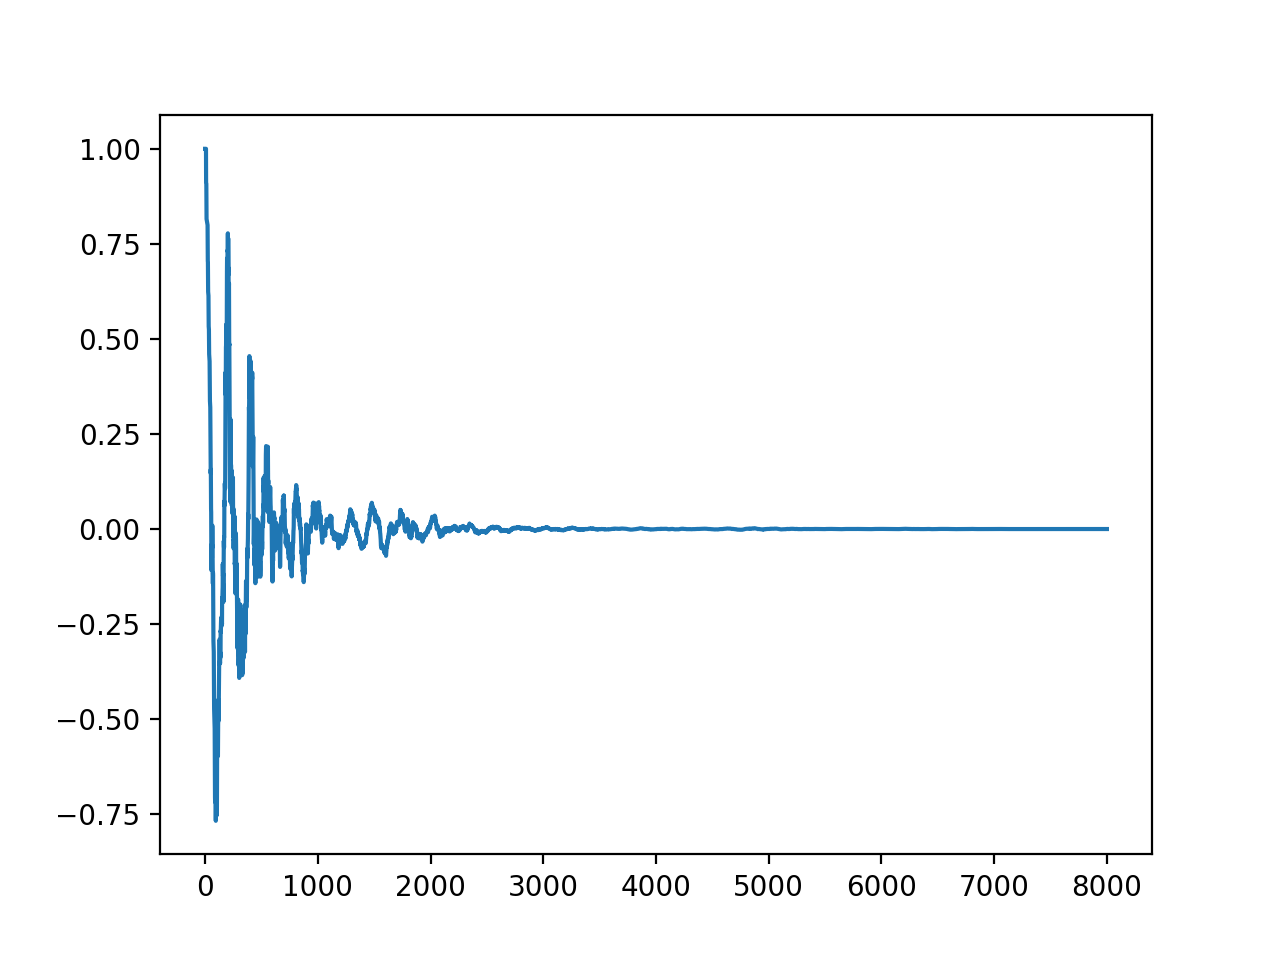

In [69]:
%matplotlib notebook
xs = univariate_shifted_step_size_test(100, 100, 0.09, 0, 1, 8000)
plt.plot(xs)

In [80]:
my_data = np.genfromtxt('data.txt', delimiter='\t')
print(my_data)

[[0.25   0.2    0.2    0.2    0.15   0.1    0.1    0.1   ]
 [0.175  0.175  0.125  0.1    0.075  0.075  0.05   0.05  ]
 [0.183  0.13   0.1    0.0833 0.05   0.033  0.033  0.033 ]
 [0.15   0.11   0.0875 0.05   0.0375 0.025  0.025  0.025 ]
 [0.13   0.1    0.07   0.05   0.03   0.02   0.02   0.02  ]]


<IPython.core.display.Javascript object>


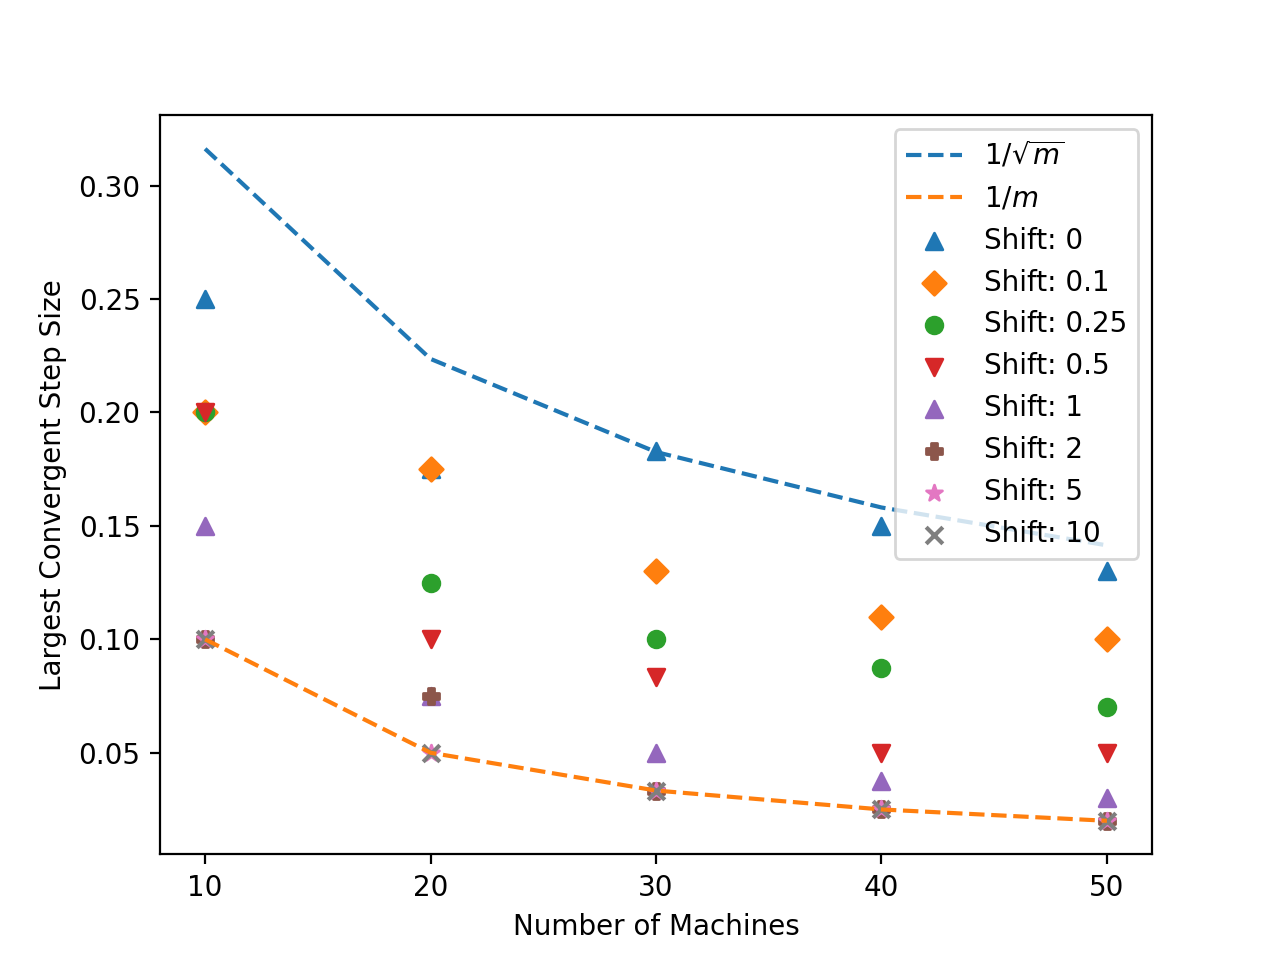

([<matplotlib.axis.XTick at 0x7fa372c16750>,
 <a list of 5 Text major ticklabel objects>)

In [100]:
xs = [10, 20, 30, 40, 50]
plt.scatter(xs, my_data.T[0], marker='^', label='Shift: 0')
plt.scatter(xs, my_data.T[1], marker='D', label='Shift: 0.1')
plt.scatter(xs, my_data.T[2], marker='o', label='Shift: 0.25')
plt.scatter(xs, my_data.T[3], marker='v', label='Shift: 0.5')
plt.scatter(xs, my_data.T[4], marker='^', label='Shift: 1')
plt.scatter(xs, my_data.T[5], marker='P', label='Shift: 2')
plt.scatter(xs, my_data.T[6], marker='*', label='Shift: 5')
plt.scatter(xs, my_data.T[7], marker='x', label='Shift: 10')
plt.plot(xs, [1/(np.sqrt(x)) for x in xs], ls='dashed', label="$1/\sqrt{m}$")
plt.plot(xs, [1/x for x in xs], ls='dashed', label="$1/m$")
plt.xlabel("Number of Machines")
plt.ylabel("Largest Convergent Step Size")
plt.legend(loc='upper right')
plt.xticks(xs)


In [10]:
def ADSAGA_LS_test(m, n, d, shift, sigma, eta, its, threshold = -1, block=1, distributed=True, SGD=False, IAG=False):
    A = np.random.normal(size=(n*block, d))
    x_true = np.random.normal(size=d)
    b = np.dot(A, x_true) + np.random.normal(scale=sigma)
    x_0 = np.random.normal(size=d)
    x_star = np.dot(np.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, b))
    SE, success = ASAGA_least_squares(A, b, m, eta, shifted_exp(shift, 1), x_0, its, threshold=threshold, block=block, distributed=distributed, SGD=SGD, IAG=IAG)
    return SE, success

def GD_LS_test(m, n, d, sigma, eta, its, threshold =-1, block=1):
    A = np.random.normal(size=(n*block, d))
    x_true = np.random.normal(size=d)
    b = np.dot(A, x_true) + np.random.normal(scale=sigma)
    x_0 = np.random.normal(size=d)
    SE, success = GD_least_squares(A, b, m, eta, x_0, its, threshold=threshold, block=block)
    return SE, success

def SAGA_LS_test(m, n, d, sigma, eta, its, threshold =-1, block=1):
    A = np.random.normal(size=(n*block, d))
    x_true = np.random.normal(size=d)
    b = np.dot(A, x_true) + np.random.normal(scale=sigma)
    x_0 = np.random.normal(size=d)
    SE, success = SAGA_least_squares(A, b, m, eta, x_0, its, threshold=threshold, block=block)
    return SE, success

In [194]:
xs = ASAGA_least_squares(np.random.normal(size=(100, 50)), np.zeros(100), m, 0.007, shifted_exp(0, 1), np.ones(50), 100, block=2)

<IPython.core.display.Javascript object>


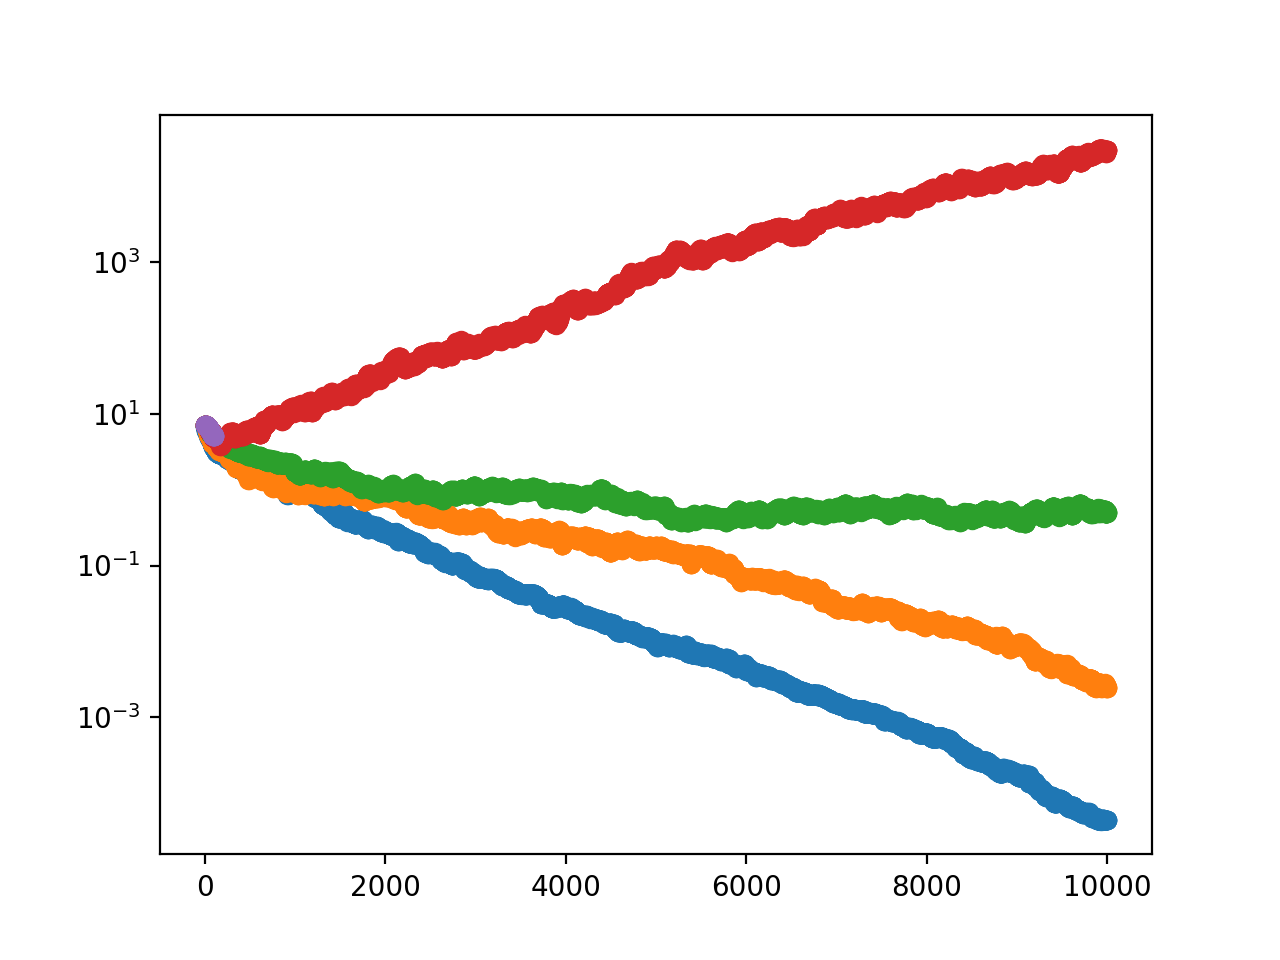

In [191]:
for m in [1, 10, 20, 50]:
    xs = ASAGA_least_squares(np.random.normal(size=(100, 50)), np.zeros(100), m, 0.011, shifted_exp(0, 1), np.ones(50), 10000)
    plt.scatter(range(len(xs)), [np.linalg.norm(x) for x in xs])
plt.yscale('log')

In [228]:
errs = ASAGA_LS_test(100, 100, 50, 0, 1.0, 0.005, 2000, block=1)
plt.scatter(range(len(errs)), errs)
plt.yscale('log')

<IPython.core.display.Javascript object>

In [11]:
# Grid Search steps sizes
# Returns best size, MSE for that size, standard dev
def grid_search_stepsizes_LS(n, m, d, sizes, sigma, its=5, reps=2, shift=0, block=1, distributed=True):
    print(sizes)
    errs_by_size = []
    stvs_by_size = []
    for size in sizes:
        errs = []
        for i in range(reps):
            SE = ADSAGA_LS_test(m, n, d, shift, sigma, size, its, block=block, distributed=distributed)
            errs.append(SE[-1])
#             print(i, size, err)
        errs_by_size.append(np.mean(errs))
        #print(errs)
        stvs_by_size.append(np.sqrt(np.mean(np.square(np.array(errs) - np.mean(errs)))))
    j =  np.argmin(errs_by_size)#, np.min(errs_by_size)
    return sizes[np.argmin(errs_by_size)], np.min(errs_by_size), stvs_by_size[j]    

# def grid_search_LS_desired_accuracy(n, m, d, sizes, sigma, threshold, max_its=5000, reps=3, shift=0, block=1, distributed=True, SGD=False, IAG=False):
#     its_by_size = []
#     stvs_by_size = []
#     for size in sizes:
#         best_its = max_its
#         iterations = []
#         for i in range(reps):
#             if shift > -0.5:
#                 SE, success = ADSAGA_LS_test(m, n, d, shift, sigma, size, best_its + 2*n, threshold =threshold, block=1, distributed=distributed, SGD=SGD, IAG=IAG)
#             else:
#                 SE, success = SAGA_LS_test(m, n, d, sigma, size, best_its + 2*n, threshold =threshold, block=1)
#             if success:
#                 iterations.append(len(SE))
#             else:
#                 iterations.append(max_its)
#                 break
# #         print(iterations)
#         its_by_size.append(np.mean(iterations))
#         best_its = min(best_its, np.max(iterations))
#         stvs_by_size.append(np.sqrt(np.mean(np.square(np.array(iterations) - np.mean(iterations)))))
#     j =  np.argmin(its_by_size)
#     print([sizes[np.argmin(its_by_size)], np.min(its_by_size), stvs_by_size[j]])
#     return [sizes[np.argmin(its_by_size)], np.min(its_by_size), stvs_by_size[j]]

def grid_search_LS_desired_accuracy(n, m, d, sizes, sigma, threshold, max_its=5000, reps=3, shift=0, block=1, distributed=True, SGD=False, IAG=False):
    its_by_size = []
    stvs_by_size = []
    counters_by_size = []
    for size in sizes:
        best_its = max_its
        iterations = []
        counter = 0
        for i in range(reps):
            if shift > -0.5:
                SE, success = ADSAGA_LS_test(m, n, d, shift, sigma, size, max_its, threshold =threshold, block=1, distributed=distributed, SGD=SGD, IAG=IAG)
            else:
                SE, success = SAGA_LS_test(m, n, d, sigma, size, max_its, threshold =threshold, block=1)
            if success:
                iterations.append(len(SE))
            else:
                iterations.append(max_its)
                counter += 1
#                 break
#         print(iterations)
        counters_by_size.append(counter)
        its_by_size.append(np.mean(iterations))
        best_its = min(best_its, np.max(iterations))
        stvs_by_size.append(np.sqrt(np.mean(np.square(np.array(iterations) - np.mean(iterations)))))
    j =  np.argmin(its_by_size)
    print([sizes[np.argmin(its_by_size)], np.min(its_by_size), stvs_by_size[j], counters_by_size[j]])
    return [sizes[np.argmin(its_by_size)], np.min(its_by_size), stvs_by_size[j]]

In [252]:
results34 = []
for shift in [0, 0.1, 0.25, 0.5, 1, 2, 5, 10]:
    for m in [30, 40]:
        n = int(100/m)*m
        print(shift, m)
        results34.append(grid_search_stepsizes_LS(n, m, int(n/2), [0.001*i for i in range(1, 11)], 1.0, its=30*n, reps=4, shift=shift, block=1))

0 30
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]
0 40
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]
0.1 30
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]
0.1 40
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]
0.25 30
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]
0.25 40
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]
0.5 30
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]
0.5 40
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]
1 30
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]
1 40
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]
2 30
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.

In [232]:
print(results)

[(0.007, 0.41227818994783194, 0.14959834592155538), (0.009000000000000001, 0.34317760133366476, 0.11975755837259901), (0.007, 0.4209479138284281, 0.22920241402740416), (0.007, 0.6071000748007915, 0.27479979835397894), (0.007, 0.7513923063109098, 0.25532669320460816), (0.006, 0.5820691614142083, 0.14726133924153903), (0.009000000000000001, 0.2540347270231367, 0.10835136461424356), (0.009000000000000001, 0.4254688250710357, 0.31038253625540285), (0.008, 0.26672965630803175, 0.08378022026412725), (0.008, 0.7814522352437481, 0.35257252685483337), (0.007, 1.0613148277284763, 0.28139018695852624), (0.007, 0.7192476954957127, 0.25737980448425957), (0.008, 0.2683463990021502, 0.08734205249235424), (0.008, 0.4289384634573026, 0.09649990906536482), (0.008, 0.431016284056044, 0.1586429054268189), (0.007, 0.6079126148712819, 0.06264243230637614), (0.007, 0.9507284219939657, 0.30014337701953275), (0.007, 0.5848343577024151, 0.08761669297116556), (0.009000000000000001, 0.3518360449227296, 0.05919518

In [253]:
results_new34 = [r[1] for r in results34]
print(results_new)
[3] + [4]

[0.10290281307454492, 0.15143154774253403, 0.18442737999370484, 0.17302921026763965, 0.1781995356959483, 0.21628930849688965, 0.5223075774891442, 0.12644274920628315, 0.12917504959970108, 0.1421987741009983, 0.10652489454743702, 0.10609050110901645, 0.25799514735825724, 0.44668645586802774, 0.08256246942659597, 0.1381849588518122, 0.1939119785017309, 0.19417423758806018, 0.10870532882712096, 0.3016206027832372, 0.39091005433374393, 0.11833945691987185, 0.10260706318303708, 0.1451675633352415, 0.11572867989283674, 0.07882730436357888, 0.2196144067948415, 0.6039722016459828, 0.13099485704096797, 0.1292568712129483, 0.1733691208430866, 0.18339490051652735, 0.11557330264560095, 0.24859027841817993, 0.43992924875996825, 0.09540860390045085, 0.08511996829030379, 0.20239493319126328, 0.19093904045433094, 0.15397205941869369, 0.2160211666132429, 0.940915434470719, 0.07552495365334441, 0.17030783249014997, 0.13736347039634564, 0.15940641890552198, 0.1856212806981676, 0.4011534011927339, 1.05837

[3, 4]

In [273]:
res_its = []
for shift in [0, 0.1, 0.25, 0.5, 1, 2, 5, 10]:
    for m in [1, 20, 30, 40, 60, 120]:
        n = int(120/m)*m
        print(shift, m)
        res_its.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 12)], 1.0, 0.1, max_its=5000, reps=4, shift=0, block=1))

0 1
[0.008, 3835.0, 331.5222466140093]
0 20
[0.007, 4013.0, 351.8813720559814]
0 30
[0.006, 4217.333333333333, 559.7822989539972]
0 40
[0.001, 5000.0, 0.0]
0 60
[0.001, 5000.0, 0.0]
0 120
[0.001, 5000.0, 0.0]
0.1 1
[0.008, 3664.5, 232.66445796468355]
0.1 20
[0.007, 4116.0, 388.83736960328287]
0.1 30
[0.007, 4682.333333333333, 225.24702489094548]
0.1 40
[0.007, 4508.0, 350.4777691475833]
0.1 60
[0.005, 4524.666666666667, 338.68110205455645]
0.1 120
[0.001, 5000.0, 0.0]
0.25 1
[0.008, 3735.75, 533.7388757622963]
0.25 20
[0.007, 3938.25, 391.56887963677605]
0.25 30
[0.007, 4343.25, 484.28471739256855]
0.25 40
[0.006, 4867.333333333333, 147.24431700031377]
0.25 60
[0.001, 5000.0, 0.0]
0.25 120
[0.001, 5000.0, 0.0]
0.5 1
[0.007, 3560.75, 587.7654187684063]
0.5 20
[0.007, 4520.25, 616.3190630671746]
0.5 30
[0.006, 4161.333333333333, 658.2913910689973]
0.5 40
[0.006, 4501.5, 205.51459802164905]
0.5 60
[0.006, 4446.666666666667, 405.40788788028726]
0.5 120
[0.001, 5000.0, 0.0]
1 1
[0.008, 3741

In [255]:
import itertools
marker = itertools.cycle(('^', 'D', 'o', 'v', '+', 'P', '*', 'x' )) 


xs = [1, 10, 20, 30, 40, 50, 100]
shifts = [0, 0.1, 0.25, 0.5, 1, 2, 5, 10]
for i in range(len(shifts)):
    values = results_new[i*7:(i + 1)*7 - 4] + results_new34[i*2:(i + 1)*2] + results_new[i*7 + 5:(i + 1)*7]
    plt.scatter(xs, values, marker=next(marker), label='Shift: %s' % shifts[i])

# plt.plot(xs, [1/(np.sqrt(x)) for x in xs], ls='dashed', label="$1/\sqrt{m}$")
# plt.plot(xs, [1/x for x in xs], ls='dashed', label="$1/m$")
plt.xlabel("Number of Machines")
plt.ylabel("MSE with best step size after 2000 iterations")
plt.legend(loc='upper left')
plt.xticks(xs)
plt.yscale('log')

<IPython.core.display.Javascript object>

In [283]:
res_its_8reps = []
for shift in [0, 0.1, 1, 10]:
    for m in [1, 10, 20, 30, 40, 60, 120]:
        n = int(120/m)*m
        print(shift, m)
        res_its_8reps.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 12)], 1.0, 0.1, max_its=8000, reps=8, shift=0, block=1))

0 1
[0.008, 3849.5, 564.7924397511001]
0 10
[0.008, 3686.125, 185.69291686814552]
0 20
[0.007, 4826.375, 1126.841707772214]
0 30
[0.007, 4090.5, 348.7011614549054]
0 40
[0.006, 5128.875, 906.5104022431293]
0 60
[0.005, 4894.875, 723.35977174225]
0 120
[0.005, 6334.0, 998.566372355889]
0.1 1
[0.008, 3827.125, 481.98351566728917]
0.1 10
[0.008, 4256.0, 513.4739526012979]
0.1 20
[0.007, 4255.375, 766.4003421026115]
0.1 30
[0.007, 4613.625, 1184.6632366942936]
0.1 40
[0.006, 4620.125, 460.0425082261421]
0.1 60
[0.006, 5170.875, 960.1849349864848]
0.1 120
[0.005, 6183.875, 551.5621990084164]
1 1
[0.007, 3917.875, 664.8259993223791]
1 10
[0.008, 4429.0, 417.74812985817186]
1 20
[0.007, 4094.25, 903.1304930628796]
1 30
[0.007, 4708.125, 692.6702746437153]
1 40
[0.007, 4699.0, 512.8903391564321]
1 60
[0.006, 4943.125, 700.0400769777399]
1 120
[0.004, 5929.5, 1276.5376022663806]
10 1
[0.007, 4279.875, 731.8506400728226]
10 10
[0.008, 4145.875, 522.1258079955443]
10 20
[0.006, 4435.0, 525.433392

In [372]:
res_its_reshape = np.array(res_its_8reps).reshape((4, 7, 3))
num_results = res_its_reshape[:,:,1]
print(num_results)
marker = itertools.cycle(('^', 'D', 'o', 'v', '+', 'P', '*', 'x' )) 


xs = [1, 10, 20, 30, 40, 60, 120]
shifts = [0, 0.1, 1, 10]
for i in range(len(shifts)):
    values = num_results[i]
    plt.scatter(xs, values, marker=next(marker), label='Shift: %s' % shifts[i])
# plt.scatter(xs, np.array(res_its_GD)[:,1], marker=next(marker), label='Synchronous GD')
plt.scatter(xs, np.array(res_its_SAGA)[:,1], marker=next(marker), label='SAGA')
    
# plt.plot(xs, [1/(np.sqrt(x)) for x in xs], ls='dashed', label="$1/\sqrt{m}$")
# plt.plot(xs, [1/x for x in xs], ls='dashed', label="$1/m$")
plt.xlabel("Number of Machines")
plt.ylabel("Iteration until MSE < 0.1")
plt.legend(loc='upper left')
plt.xticks(xs)

[[3849.5   3686.125 4826.375 4090.5   5128.875 4894.875 6334.   ]
 [3827.125 4256.    4255.375 4613.625 4620.125 5170.875 6183.875]
 [3917.875 4429.    4094.25  4708.125 4699.    4943.125 5929.5  ]
 [4279.875 4145.875 4435.    4311.875 5051.    4569.125 6230.875]]


<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x7fa335f2b490>,
 <a list of 7 Text major ticklabel objects>)

In [343]:
res_its_reshape = np.array(res_its).reshape((6, 6, 3))
num_results = res_its_reshape[:,:,1]
marker = itertools.cycle(('^', 'D', 'o', 'v', '+', 'P', '*', 'x' )) 


xs = [1, 20, 30, 40, 60, 120]
shifts = [0, 0.1, 0.5, 1, 5, 10]
for i in range(len(shifts)):
    values = num_results[i]
    plt.scatter(xs, values, marker=next(marker), label='Shift: %s' % shifts[i])

# plt.plot(xs, [1/(np.sqrt(x)) for x in xs], ls='dashed', label="$1/\sqrt{m}$")
# plt.plot(xs, [1/x for x in xs], ls='dashed', label="$1/m$")
plt.xlabel("Number of Machines")
plt.ylabel("Iteration until MSE < 0.1")
plt.legend(loc='upper left')
plt.xticks(xs)

<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x7fa32cfdbad0>,
 <a list of 6 Text major ticklabel objects>)

<IPython.core.display.Javascript object>


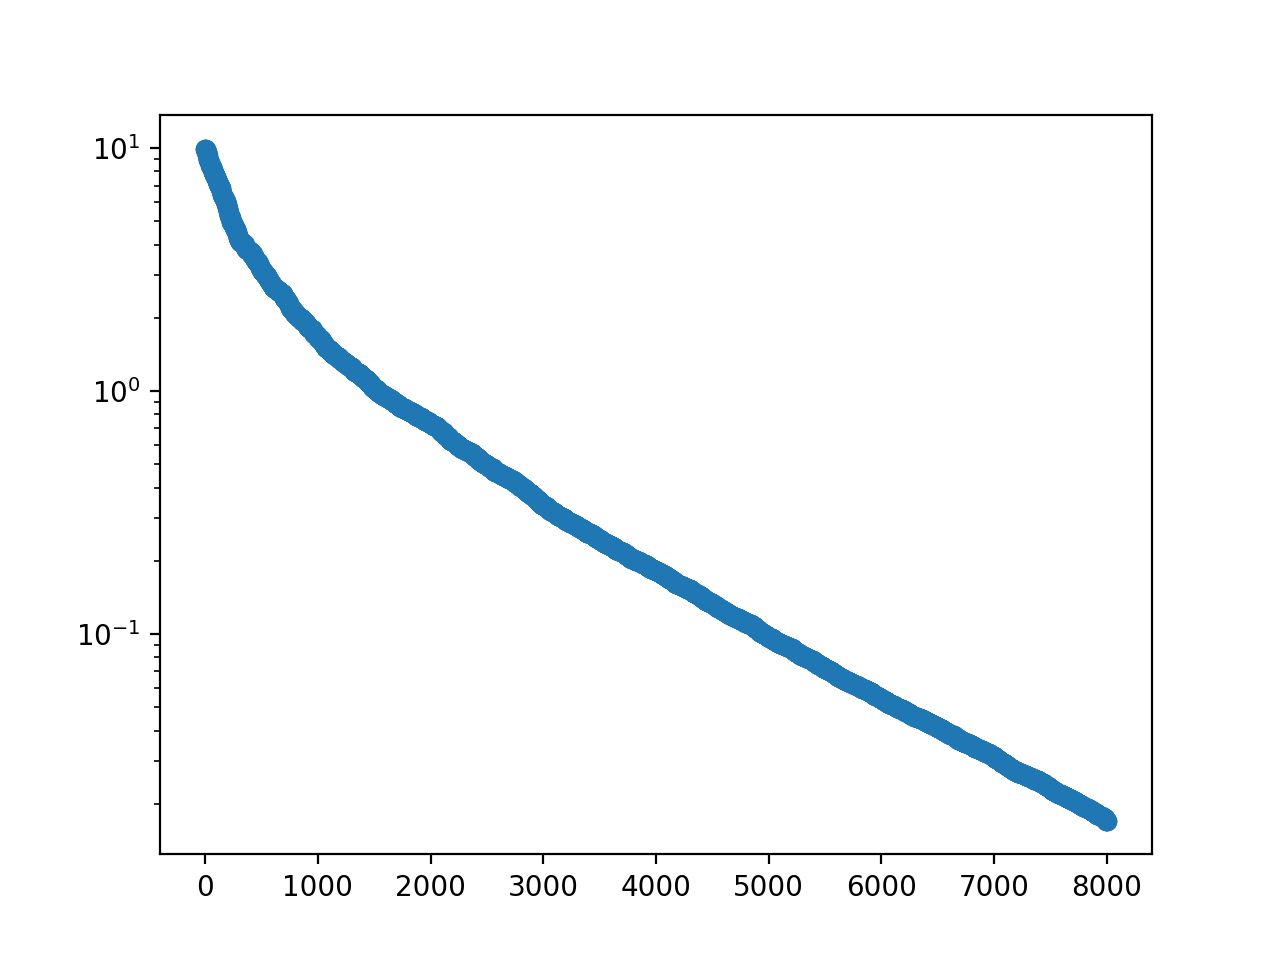

In [382]:
SE, success = GD_LS_test(20, 120, 60, 0, 0.004, 8000)
plt.scatter(range(len(SE)), SE)
plt.yscale('log')

In [360]:
res_its_GD = []
for shift in [-1]:
    for m in [1, 10, 20, 30, 40, 60, 120]:
        n = int(120/m)*m
        print(shift, m)
        res_its_GD.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 40)],0.0, 0.1, max_its=8000, reps=8, shift=-1, block=1))

-1 1
[0.023, 1603.375, 137.23058833583713]
-1 10
[0.018000000000000002, 1920.625, 349.4413174983748]
-1 20
[0.016, 2099.0, 400.36982903310786]
-1 30
[0.014, 2395.25, 295.51596826567595]
-1 40
[0.01, 2766.5, 328.1314523175125]
-1 60
[0.01, 3431.25, 351.59378194160377]
-1 120
[0.006, 6037.666666666667, 1592.6645039750908]


In [345]:
print(np.array(res_its_GD)[:,1])

[3803.375 4303.625 4848.625 4899.375 4741.125 4884.    6166.625]


In [12]:
res_its_SAGA = []
for shift in [-1]:
    for m in [1, 10, 20, 30, 40, 60, 120]:
        n = int(120/m)*m
        print(shift, m)
        res_its_SAGA.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=8000, reps=8, shift=-1, block=1))

-1 1
[0.008, 4385.75, 640.2272545744987, 0]
-1 10


KeyboardInterrupt: 

In [386]:
print(res_its_reshape)

res_its_8reps_eps001 = []
for shift in [0, 100]:
    for m in [1, 10, 20, 30, 40, 60, 120]:
        n = int(120/m)*m
        print(shift, m)
        res_its_8reps_eps001.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(4, 10)], 1.0, 0.01, max_its=12000, reps=8, shift=0, block=1))

[[[8.00000000e-03 3.84950000e+03 5.64792440e+02]
  [8.00000000e-03 3.68612500e+03 1.85692917e+02]
  [7.00000000e-03 4.82637500e+03 1.12684171e+03]
  [7.00000000e-03 4.09050000e+03 3.48701161e+02]
  [6.00000000e-03 5.12887500e+03 9.06510402e+02]
  [5.00000000e-03 4.89487500e+03 7.23359772e+02]
  [5.00000000e-03 6.33400000e+03 9.98566372e+02]]

 [[8.00000000e-03 3.82712500e+03 4.81983516e+02]
  [8.00000000e-03 4.25600000e+03 5.13473953e+02]
  [7.00000000e-03 4.25537500e+03 7.66400342e+02]
  [7.00000000e-03 4.61362500e+03 1.18466324e+03]
  [6.00000000e-03 4.62012500e+03 4.60042508e+02]
  [6.00000000e-03 5.17087500e+03 9.60184935e+02]
  [5.00000000e-03 6.18387500e+03 5.51562199e+02]]

 [[7.00000000e-03 3.91787500e+03 6.64825999e+02]
  [8.00000000e-03 4.42900000e+03 4.17748130e+02]
  [7.00000000e-03 4.09425000e+03 9.03130493e+02]
  [7.00000000e-03 4.70812500e+03 6.92670275e+02]
  [7.00000000e-03 4.69900000e+03 5.12890339e+02]
  [6.00000000e-03 4.94312500e+03 7.00040077e+02]
  [4.00000000e-0

In [389]:
grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001], 1.0, 0.01, max_its=20, reps=8, shift=10, block=1)

11.808451801396048
10.977265354606292
10.198611218280574
10.114420921978581
11.00878850631964
10.075407440139875
10.513130316558545
10.462933086825817
10.52000843755917
14.292209413771396
10.503134782152925
10.098983287410057
11.40855633826258
10.242611099560325
10.27244723799119
10.950615710114127
10.537200547715585
11.298803243668978
10.203442551825972
10.049498170387723
10.99029237343136
11.470923257305385
10.284203134232357
11.440987838413031
11.160761699641942
10.523396098927797
10.066552521428745
11.42201643781992
10.071686354824358
10.53297648190626
11.564701500769631
10.101863527447593
10.999138171088081
10.799093077883933
10.048783166048617
11.505898419164492
10.509992063756945
10.536007423678678
11.878472460773368
10.14195425216887
12.32313734017136
12.336408322000326
10.912430100480416
11.696413243432408
10.162837769617276
11.278681226267524
10.485653587596827
10.111931062911381
10.5324516530226
11.576250108921881
10.725832544011654
10.089205919406133
10.89531082286371
11.29

[0.001, 20.0, 0.0]

<IPython.core.display.Javascript object>


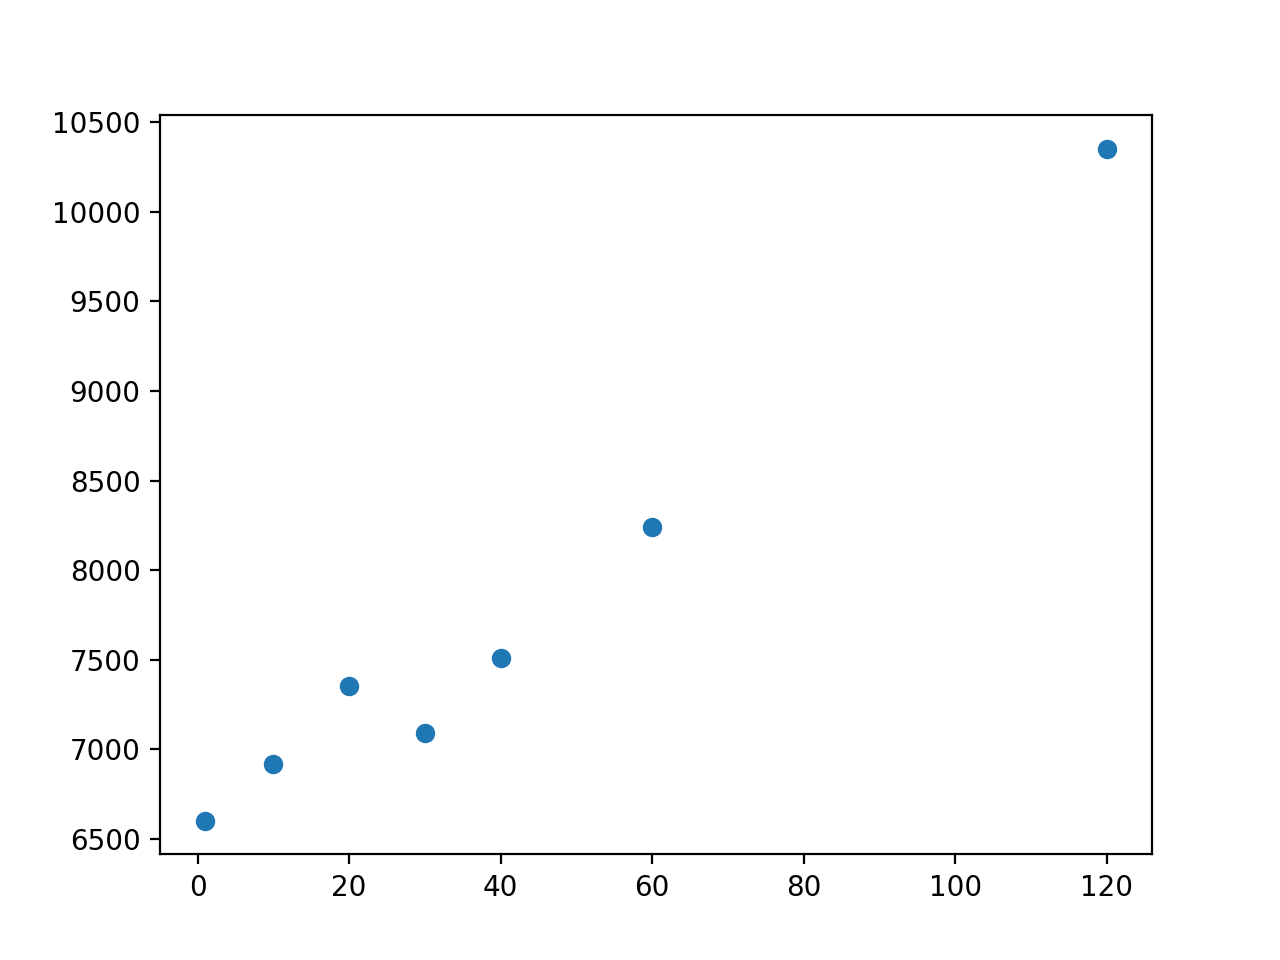

In [393]:
plt.scatter([1, 10, 20, 30, 40, 60, 120], np.array(res_its_8reps_eps001)[:7,1])

In [399]:
res_big = []
for shift in [0, 100]:
    for m in [1, 10, 20, 40, 60, 90, 120, 180, 360]:
        n = int(360/m)*m
        print(shift, m)
        res_big.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 10)], 1.0, 1, max_its=15000, reps=8, shift=0, block=1))

0 1
[0.003, 7082.625, 411.3653903465871]
0 10
[0.003, 7381.5, 576.749945817076]
0 20
[0.002, 7887.375, 847.5738813666924]
0 40
[0.002, 7801.75, 945.1922754127861]
0 60
[0.002, 8122.25, 898.8678643159961]
0 90
[0.002, 8292.375, 971.5887681395869]
0 120
[0.002, 7923.625, 332.8486658753494]
0 180
[0.002, 8125.25, 638.1674447196441]
0 360
[0.001, 12501.375, 1413.2190150061667]
100 1
[0.003, 6942.375, 384.5900211588959]
100 10
[0.002, 7713.125, 980.4291710138983]
100 20
[0.002, 7595.75, 623.8915671012071]
100 40
[0.002, 7568.125, 1049.6384422147466]
100 60
[0.002, 7966.75, 696.6715061634142]
100 90
[0.002, 7966.75, 434.26453631398454]
100 120
[0.002, 7972.25, 520.5775038358842]
100 180
[0.002, 8567.875, 1301.3845931833525]
100 360
[0.001, 13937.5, 1062.5]


In [54]:
res_its_SAGA = []
for shift in [-1, 0, 0.1, 1, 10]:
    for m in [1, 10, 20, 40, 60, 120]:
        for d in [True, False]:
            n = int(120/m)*m
            result = grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=8000, reps=8, shift=shift, block=1, distributed=d)
            print(shift, m, result)
            res_its_SAGA.append(result)
            
# for shift in [10]:
#     for m in [120]:
#         for d in [True, False]:
#             n = int(120/m)*m
#             result = grid_search_LS_desired_accuracy(n, m, int(n/2), [0.0005*i for i in range(1, 14)],1.0, 0.1, max_its=12000, reps=8, shift=shift, block=1, distributed=d)
#             print(shift, m, result)
            
# res_its_SAGA[-1] = [0.0035, 8447.0, 1273.1303939502818]
# res_its_SAGA[-2] = [0.0025, 10943.5, 1056.5]

[0.0025, 10555.25, 1321.2069056359037]
10 120 [0.0025, 10555.25, 1321.2069056359037]
[0.0035, 7838.25, 1006.0387355862596]
10 120 [0.0035, 7838.25, 1006.0387355862596]


In [18]:
res_its_SAGA_block2 = []
for shift in [-1, 0, 0.1, 1, 10]:
    for m in [1, 10, 20, 40, 60, 120]:
        for d in [True, False]:
            n = int(120/m)*m
            result = grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=8000, reps=8, shift=shift, block=2, distributed=d)
            print(shift, m, result)
            res_its_SAGA_block2.append(result)

[0.008, 3928.375, 611.2998318133255]
-1 1 [0.008, 3928.375, 611.2998318133255]
[0.008, 4056.125, 716.022946123237]
-1 1 [0.008, 4056.125, 716.022946123237]
[0.008, 4043.625, 384.3370712993999]
-1 10 [0.008, 4043.625, 384.3370712993999]
[0.008, 4256.0, 901.2305476402805]
-1 10 [0.008, 4256.0, 901.2305476402805]
[0.008, 4668.625, 880.5840302747944]
-1 20 [0.008, 4668.625, 880.5840302747944]
[0.007, 4396.25, 751.2071535202524]
-1 20 [0.007, 4396.25, 751.2071535202524]
[0.007, 4726.0, 634.8903448627959]
-1 40 [0.007, 4726.0, 634.8903448627959]
[0.007, 4509.0, 507.5189651628794]
-1 40 [0.007, 4509.0, 507.5189651628794]
[0.006, 4827.625, 622.8464773722334]
-1 60 [0.006, 4827.625, 622.8464773722334]
[0.006, 4734.125, 585.8857477145182]
-1 60 [0.006, 4734.125, 585.8857477145182]
[0.005, 6440.0, 889.558317368794]
-1 120 [0.005, 6440.0, 889.558317368794]
[0.005, 6295.625, 898.5235024054741]
-1 120 [0.005, 6295.625, 898.5235024054741]
[0.008, 4033.0, 475.90571545212606]
0 1 [0.008, 4033.0, 475.90

In [19]:
res_its_SAGA_block2_60 = []
for shift in [-1, 0, 0.1, 1, 10]:
    for m in [1, 10, 20, 40, 60]:
        for d in [True, False]:
            n = int(60/m)*m
            result = grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=8000, reps=8, shift=shift, block=2, distributed=d)
            print(shift, m, result)
            res_its_SAGA_block2_60.append(result)

[0.015, 1905.75, 293.85870329122463]
-1 1 [0.015, 1905.75, 293.85870329122463]
[0.012, 1972.75, 431.8971955222678]
-1 1 [0.012, 1972.75, 431.8971955222678]
[0.013000000000000001, 2124.75, 355.7087115885693]
-1 10 [0.013000000000000001, 2124.75, 355.7087115885693]
[0.013000000000000001, 2054.625, 585.7746873798833]
-1 10 [0.013000000000000001, 2054.625, 585.7746873798833]
[0.013000000000000001, 1833.0, 55.5517776493246]
-1 20 [0.013000000000000001, 1833.0, 55.5517776493246]
[0.014, 2087.125, 234.36746654559374]
-1 20 [0.014, 2087.125, 234.36746654559374]
[0.012, 1706.875, 270.24546134024155]
-1 40 [0.012, 1706.875, 270.24546134024155]
[0.013000000000000001, 1790.875, 361.9397178743996]
-1 40 [0.013000000000000001, 1790.875, 361.9397178743996]
[0.009000000000000001, 2753.25, 703.1389887497351]
-1 60 [0.009000000000000001, 2753.25, 703.1389887497351]
[0.008, 2881.5, 576.1967979779131]
-1 60 [0.008, 2881.5, 576.1967979779131]
[0.015, 1895.125, 302.49274268153937]
0 1 [0.015, 1895.125, 302.

In [20]:
res_its_SAGA_block4_30 = []
for shift in [-1, 0, 0.1, 1, 10]:
    for m in [1, 10, 20, 30]:
        for d in [True, False]:
            n = int(30/m)*m
            result = grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=8000, reps=8, shift=shift, block=4, distributed=d)
            print(shift, m, result)
            res_its_SAGA_block4_30.append(result)

[0.019, 1107.75, 687.9419942844019]
-1 1 [0.019, 1107.75, 687.9419942844019]
[0.019, 1090.875, 326.12744345577545]
-1 1 [0.019, 1090.875, 326.12744345577545]
[0.019, 1103.125, 400.1029359739816]
-1 10 [0.019, 1103.125, 400.1029359739816]
[0.018000000000000002, 989.5, 241.1514047232568]
-1 10 [0.018000000000000002, 989.5, 241.1514047232568]
[0.015, 1000.375, 345.48514349389905]
-1 20 [0.015, 1000.375, 345.48514349389905]
[0.017, 1096.375, 344.7636645225248]
-1 20 [0.017, 1096.375, 344.7636645225248]
[0.014, 1280.375, 490.0239630620119]
-1 30 [0.014, 1280.375, 490.0239630620119]
[0.017, 1075.375, 192.15614581636467]
-1 30 [0.017, 1075.375, 192.15614581636467]
[0.018000000000000002, 1185.375, 301.3884277390225]
0 1 [0.018000000000000002, 1185.375, 301.3884277390225]
[0.018000000000000002, 1351.125, 548.8211087184967]
0 1 [0.018000000000000002, 1351.125, 548.8211087184967]
[0.018000000000000002, 1131.625, 302.73211652383367]
0 10 [0.018000000000000002, 1131.625, 302.73211652383367]
[0.0180

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


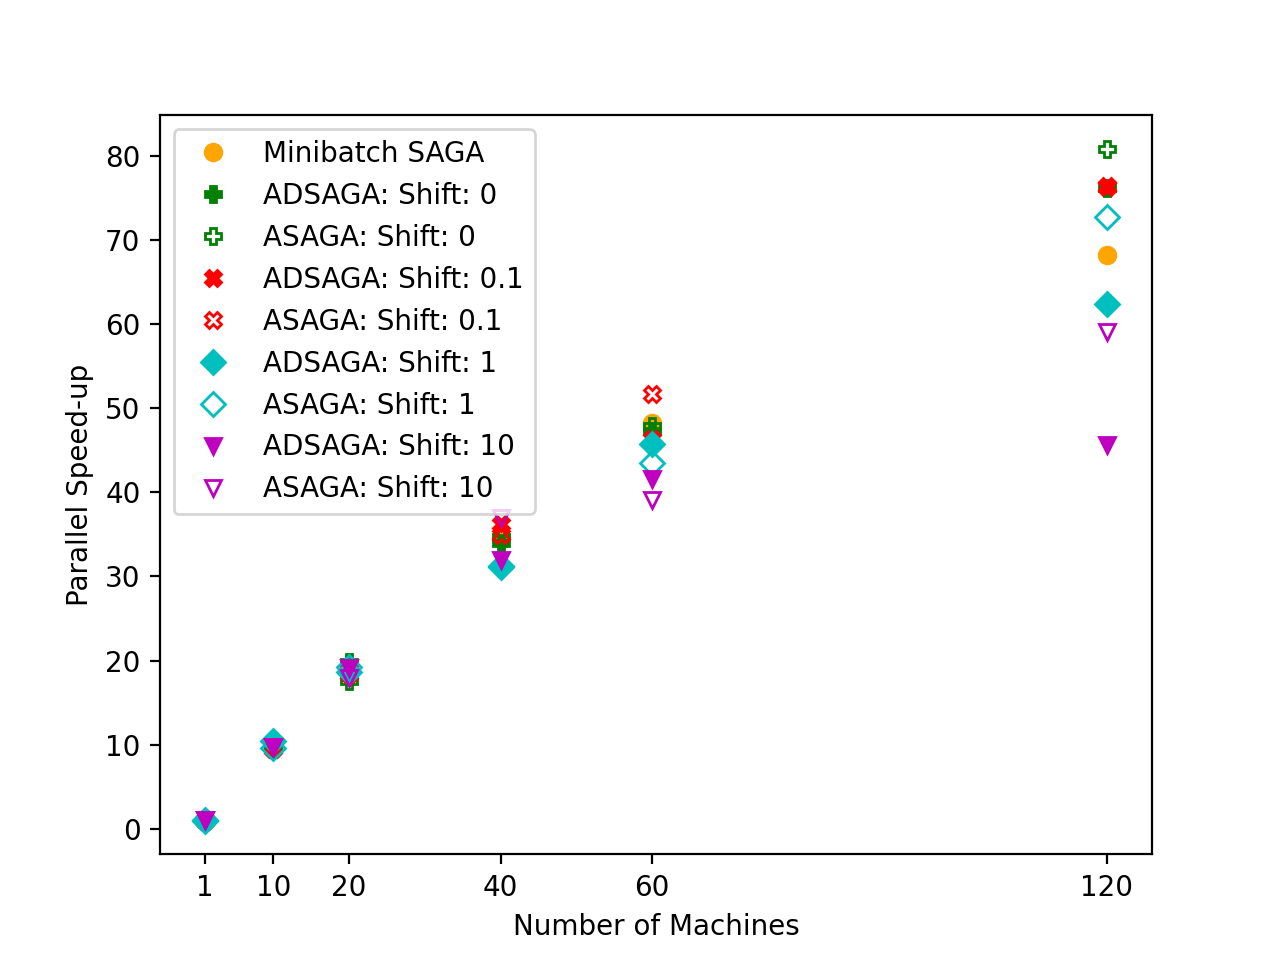

([<matplotlib.axis.XTick at 0x7f8004de0550>,
 <a list of 6 Text major ticklabel objects>)

In [70]:
%matplotlib notebook
res_its_saga_reshape = np.array(res_its_SAGA).reshape((5, 6, 2, 3))
num_results = res_its_saga_reshape[:,:,:,1]
import itertools
# print(num_results)
marker = itertools.cycle(('o', 'P', 'X', 'D', 'v', '>' )) 
colors = itertools.cycle(('orange', 'g', 'r', 'c', 'm', 'y', 'k'))

xs = [1, 10, 20, 40, 60, 120]
shifts = [-1, 0, 0.1, 1, 10]
# for i in range(len(shifts)):
#     values_d = num_results[i].T[0]
#     values_c = num_results[i].T[1]
#     m=next(marker)
#     c=next(colors)
#     if shifts[i] == -1:
#         plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='Minibatch SAGA')
#         #plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])
#     else:
#         plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='ADSAGA: Shift: %s' % shifts[i])
#         plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])

# # plt.plot(xs, [1/(np.sqrt(x)) for x in xs], ls='dashed', label="$1/\sqrt{m}$")
# # plt.plot(xs, [1/x for x in xs], ls='dashed', label="$1/m$")
# plt.xlabel("Number of Machines")
# plt.ylabel("Iteration until MSE < 0.1")
# plt.legend(loc='upper left')
# plt.xticks(xs)


for i in range(len(shifts)):
    values_d = np.array(xs)*np.mean(num_results[:,0,:])/(num_results[i].T[0])
    values_c = np.array(xs)*np.mean(num_results[:,0,:])/(num_results[i].T[1])
    m=next(marker)
    c=next(colors)
    if shifts[i] == -1:
        plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='Minibatch SAGA')
        #plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])
    else:
        plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='ADSAGA: Shift: %s' % shifts[i])
        plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])

# plt.plot(xs, [1/(np.sqrt(x)) for x in xs], ls='dashed', label="$1/\sqrt{m}$")
# plt.plot(xs, [1/x for x in xs], ls='dashed', label="$1/m$")
plt.xlabel("Number of Machines")
plt.ylabel("Parallel Speed-up")
plt.legend(loc='upper left')
plt.xticks(xs)

In [33]:
from matplotlib.lines import Line2D
print(Line2D.fillStyles)
print(Line2D.lineStyles)
plt.plot([1, 2], [1, 2], marker='o', fillstyle='none', linestyle='None')

('full', 'left', 'right', 'bottom', 'top', 'none')
{'-': '_draw_solid', '--': '_draw_dashed', '-.': '_draw_dash_dot', ':': '_draw_dotted', 'None': '_draw_nothing', ' ': '_draw_nothing', '': '_draw_nothing'}


In [56]:
A = np.random.normal(size=(120, 60))
print(np.linalg.norm(np.dot(A.T, A), ord=2))
print(np.linalg.norm(np.dot(A.T, A), ord=-2))

328.0035717485265
13.016081487926341


<IPython.core.display.Javascript object>


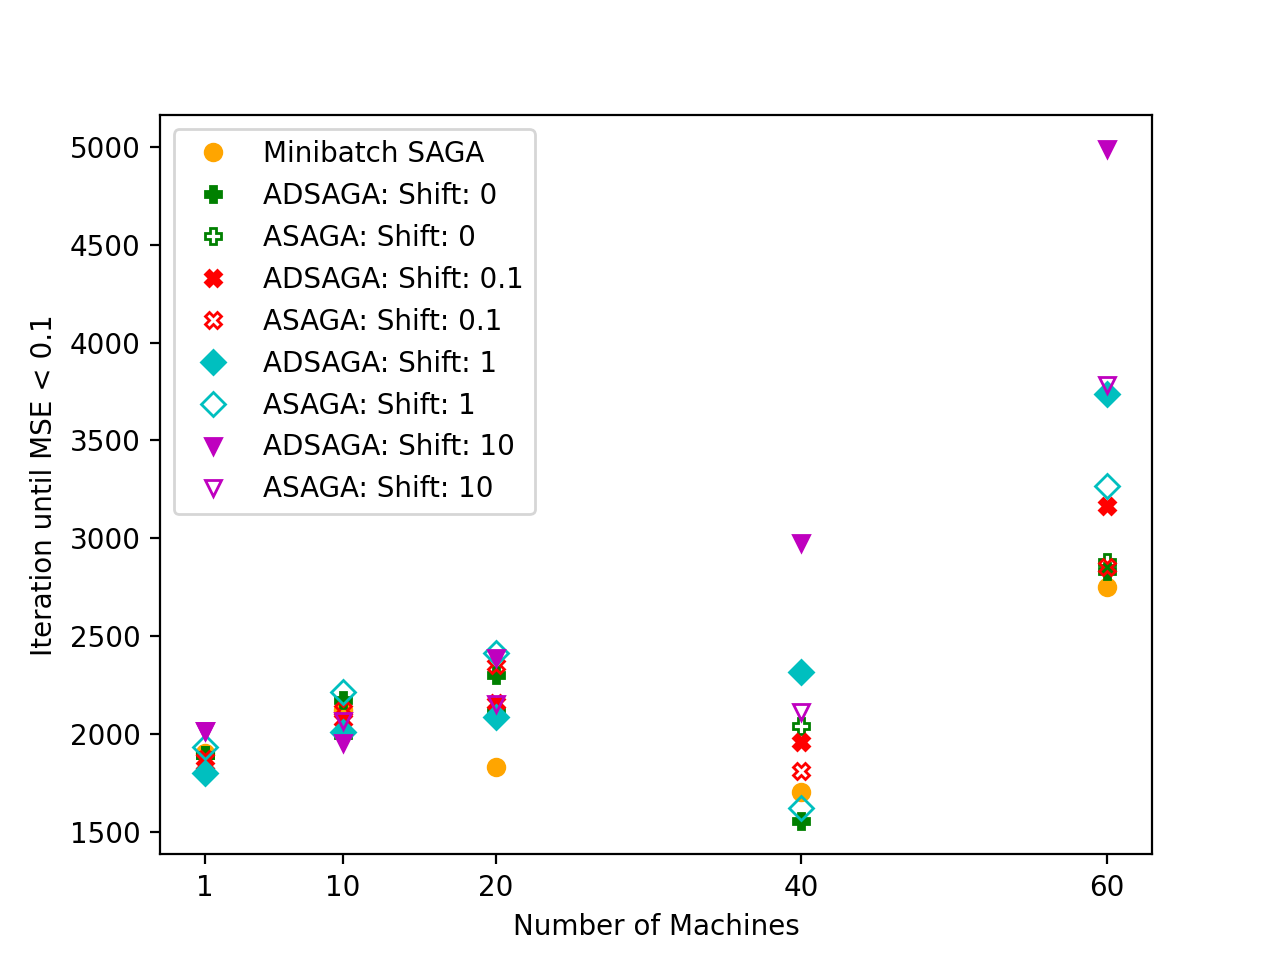

([<matplotlib.axis.XTick at 0x7f801978fd90>,
 <a list of 5 Text major ticklabel objects>)

In [58]:
res_its_SAGA_block2_60_reshape = np.array(res_its_SAGA_block2_60).reshape((5, 5, 2, 3))
num_results = res_its_SAGA_block2_60_reshape[:,:,:,1]
import itertools
# print(num_results)
marker = itertools.cycle(('o', 'P', 'X', 'D', 'v', '>' )) 
colors = itertools.cycle(('orange', 'g', 'r', 'c', 'm', 'y', 'k'))

xs = [1, 10, 20, 40, 60]
shifts = [-1, 0, 0.1, 1, 10]
for i in range(len(shifts)):
    values_d = num_results[i].T[0]
    values_c = num_results[i].T[1]
    m=next(marker)
    c=next(colors)
    if shifts[i] == -1:
        plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='Minibatch SAGA')
        #plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])
    else:
        plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='ADSAGA: Shift: %s' % shifts[i])
        plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])

# plt.plot(xs, [1/(np.sqrt(x)) for x in xs], ls='dashed', label="$1/\sqrt{m}$")
# plt.plot(xs, [1/x for x in xs], ls='dashed', label="$1/m$")
plt.xlabel("Number of Machines")
plt.ylabel("Iteration until MSE < 0.1")
plt.legend(loc='upper left')
plt.xticks(xs)

<IPython.core.display.Javascript object>


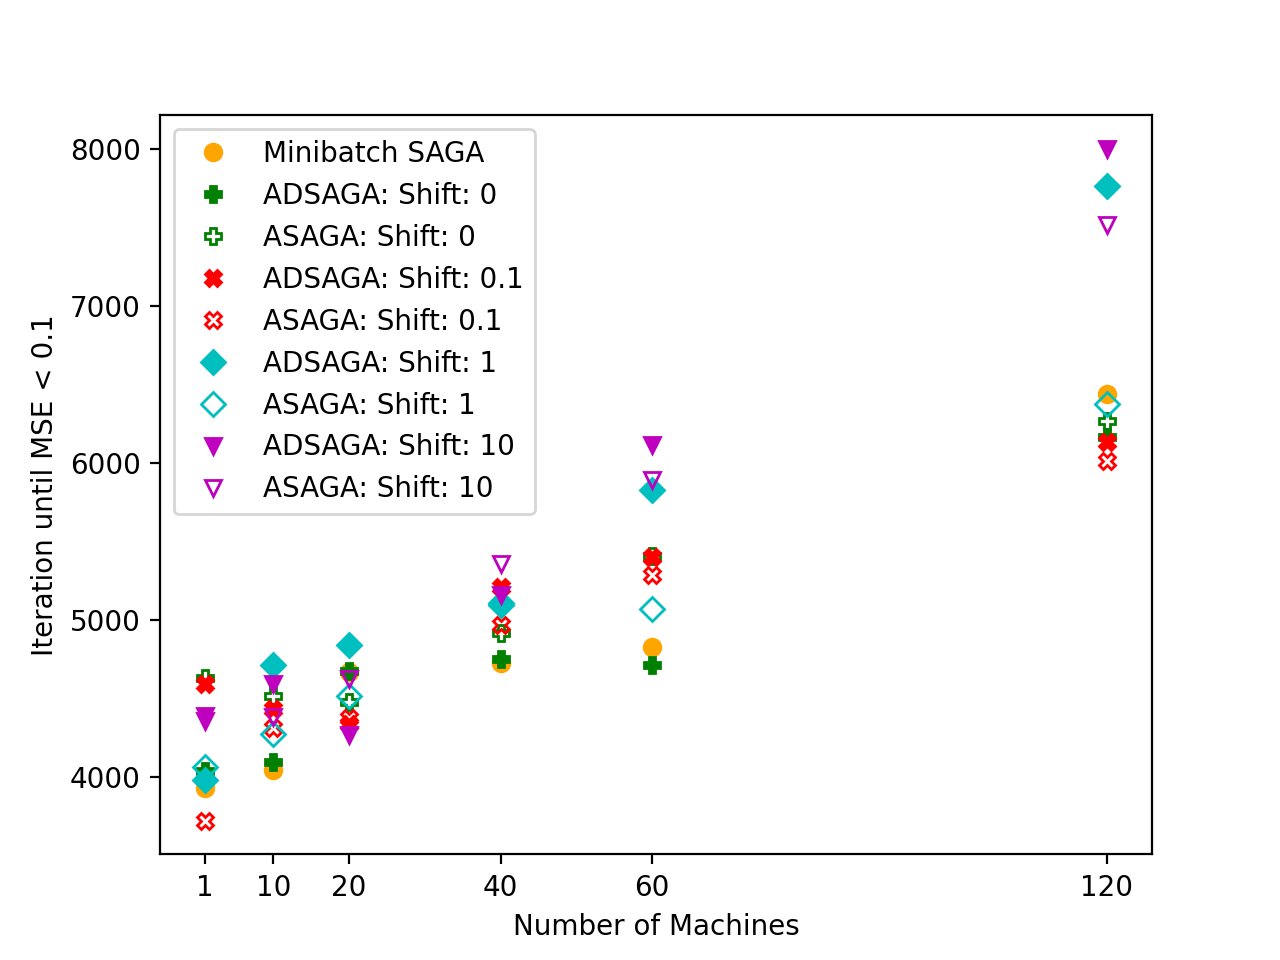

([<matplotlib.axis.XTick at 0x7f801d68afd0>,
 <a list of 6 Text major ticklabel objects>)

In [61]:
res_its_SAGA_block2_reshape = np.array(res_its_SAGA_block2).reshape((5, 6, 2, 3))
num_results = res_its_SAGA_block2_reshape[:,:,:,1]
import itertools
# print(num_results)
marker = itertools.cycle(('o', 'P', 'X', 'D', 'v', '>' )) 
colors = itertools.cycle(('orange', 'g', 'r', 'c', 'm', 'y', 'k'))

xs = [1, 10, 20, 40, 60, 120]
shifts = [-1, 0, 0.1, 1, 10]
for i in range(len(shifts)):
    values_d = num_results[i].T[0]
    values_c = num_results[i].T[1]
    m=next(marker)
    c=next(colors)
    if shifts[i] == -1:
        plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='Minibatch SAGA')
        #plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])
    else:
        plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='ADSAGA: Shift: %s' % shifts[i])
        plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])

# plt.plot(xs, [1/(np.sqrt(x)) for x in xs], ls='dashed', label="$1/\sqrt{m}$")
# plt.plot(xs, [1/x for x in xs], ls='dashed', label="$1/m$")
plt.xlabel("Number of Machines")
plt.ylabel("Iteration until MSE < 0.1")
plt.legend(loc='upper left')
plt.xticks(xs)

In [79]:
res_its_SOTA = []
for shift in [0, 0.1, 1, 10]:
    for m in [10, 20, 40, 60, 120]:
        for opts in [(True, False, False), (False, False, False), (True, True, False), (True, False, True)]:
            n = int(120/m)*m
            result = grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=10000, reps=8, shift=shift, block=1, distributed=opts[0], SGD=opts[1], IAG=opts[2])
            print(shift, m, result)
            res_its_SOTA.append(result)

[0.008, 4538.625, 486.9640483392999, 0]
0 10 [0.008, 4538.625, 486.9640483392999]
[0.008, 4401.25, 565.4351753295863, 0]
0 10 [0.008, 4401.25, 565.4351753295863]
[0.019, 7073.0, 3779.1944578176976, 5]
0 10 [0.019, 7073.0, 3779.1944578176976]
[0.007, 4166.5, 672.5828945193299, 0]
0 10 [0.007, 4166.5, 672.5828945193299]
[0.007, 4313.5, 343.13007737591295, 0]
0 20 [0.007, 4313.5, 343.13007737591295]
[0.007, 4811.75, 380.45293729974014, 0]
0 20 [0.007, 4811.75, 380.45293729974014]
[0.017, 9098.0, 2386.4676825802608, 7]
0 20 [0.017, 9098.0, 2386.4676825802608]
[0.006, 4629.25, 470.7610195205206, 0]
0 20 [0.006, 4629.25, 470.7610195205206]
[0.007, 4934.125, 360.0796569857842, 0]
0 40 [0.007, 4934.125, 360.0796569857842]
[0.006, 5147.75, 581.0530849242606, 0]
0 40 [0.006, 5147.75, 581.0530849242606]
[0.011, 7436.625, 3316.587061178253, 5]
0 40 [0.011, 7436.625, 3316.587061178253]
[0.006, 5055.125, 514.9906400848466, 0]
0 40 [0.006, 5055.125, 514.9906400848466]
[0.006, 5310.375, 916.7083693165

In [72]:
SE, success = ADSAGA_LS_test(20, 120, 60, 0, 1.0, 0.01, 8000, threshold = 0.1, block=1, distributed=True, SGD=False, IAG=False)

<IPython.core.display.Javascript object>


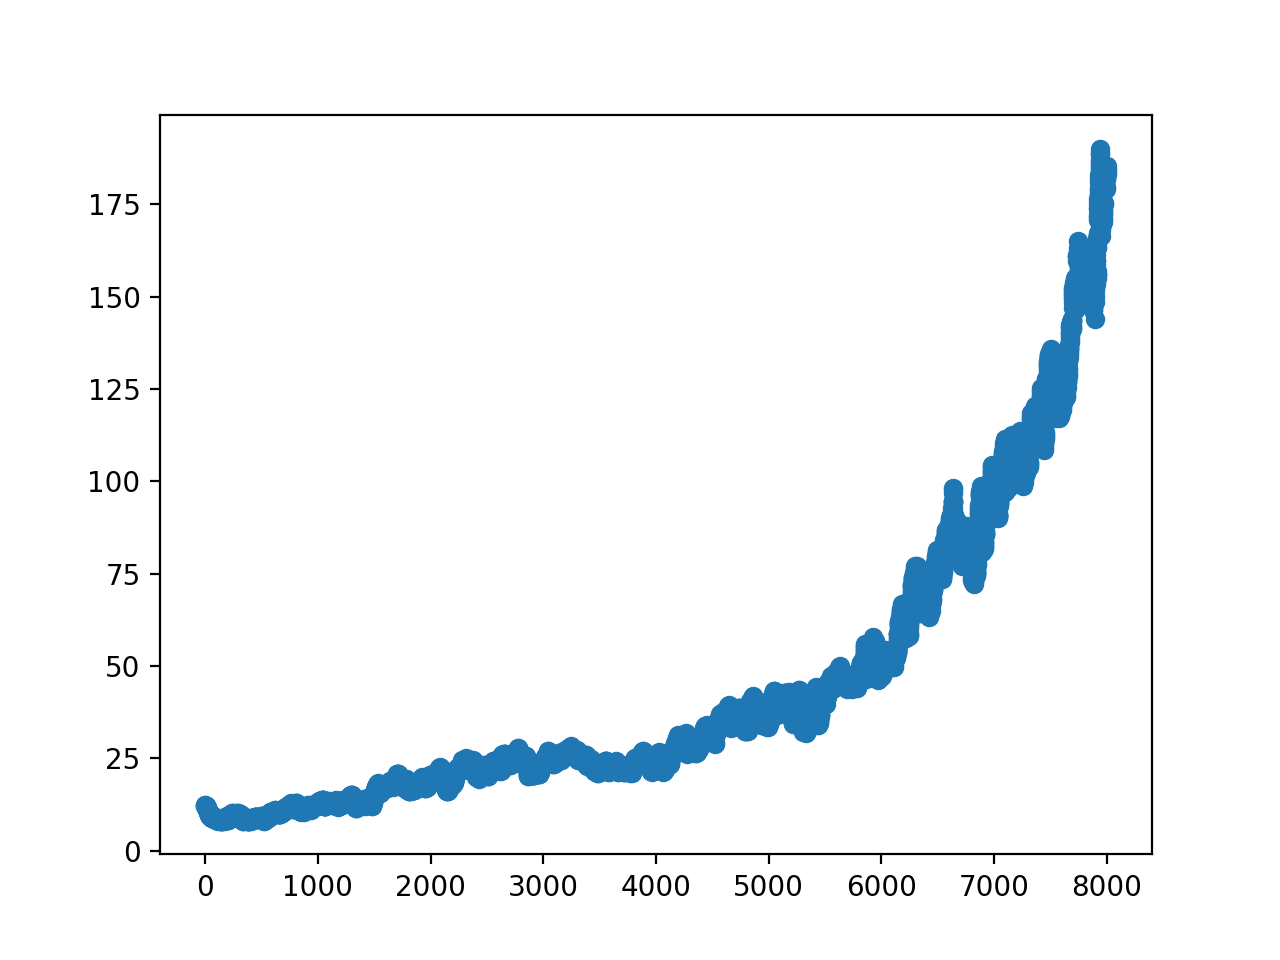

In [45]:
%matplotlib notebook
plt.scatter(range(len(SE)), SE)

In [74]:
grid_search_LS_desired_accuracy(120, 20, 60, [0.001*i for i in range(1, 20)],10.0, 0.1, max_its=8000, reps=8, shift=0, block=1, SGD=True, IAG=False)

[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 4829]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 3813, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000]
[0.007, 7476.625, 1384.72009242843]


[0.007, 7476.625, 1384.72009242843]

In [70]:
for step in [0.001*i for i in range(20)]:
    SE, success = ADSAGA_LS_test(20, 120, 60, 0, 1.0, 0.011, 10000, threshold = 0.1, block=1, distributed=True, SGD=False, IAG=False)
    print(success, len(SE))
#     if success:
#         break

False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001
False 10001


In [63]:
plt.scatter(range(len(SE)), SE)
# plt.yscale('log')

<IPython.core.display.Javascript object>

In [95]:
res_its_SOTA = res_its_SOTA[:-5]
res_its_SOTA_reshape = np.array(res_its_SOTA).reshape((4, 5, 4, 3))
num_results = res_its_SOTA_reshape[:,:,:,1]
import itertools
print(num_results)
marker = itertools.cycle(('o', 'P', 'X', 'D', 'v', '>' )) 
colors = itertools.cycle(('orange', 'g', 'r', 'c', 'm', 'y', 'k'))

xs = [10, 20, 40, 60, 120]
shifts = [0, 0.1, 1, 10]
for i in range(len(shifts)):
    values_d = num_results[i].T[0]
    values_c = num_results[i].T[1]
    values_sgd = num_results[i].T[2]
    values_iag = num_results[i].T[3]
    m=next(marker)
    c=next(colors)
    if shifts[i] == -1:
        plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='Minibatch SAGA')
        #plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])
    elif shifts[i] == 0 or shifts[i] == 10:
        plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='ADSAGA: Shift: %s' % shifts[i])
        plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])
        plt.plot(xs, values_sgd, marker=m, fillstyle='left', linestyle='None', color=c, label='SGD: Shift: %s' % shifts[i])
        plt.plot(xs, values_iag, marker=m, fillstyle='right', linestyle='None', color=c, label='IAG: Shift: %s' % shifts[i])

# plt.plot(xs, [1/(np.sqrt(x)) for x in xs], ls='dashed', label="$1/\sqrt{m}$")
# plt.plot(xs, [1/x for x in xs], ls='dashed', label="$1/m$")
plt.xlabel("Number of Machines")
plt.ylabel("Iteration until MSE < 0.1")
plt.legend(loc='upper left')
plt.xticks(xs)

ValueError: cannot reshape array of size 195 into shape (4,5,4,3)

In [87]:
for shift in [-1]:
    for m in [10, 20, 40, 60, 120]:
        n = int(120/m)*m
        result = grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=10000, reps=8, shift=shift, block=1)
        print(shift, m, result)
        res_its_SOTA.append(result)

[0.008, 4144.5, 386.64033674721526, 0]
-1 10 [0.008, 4144.5, 386.64033674721526]
[0.007, 4513.0, 381.42233809780987, 0]
-1 20 [0.007, 4513.0, 381.42233809780987]
[0.007, 4370.625, 387.38931887056464, 0]
-1 40 [0.007, 4370.625, 387.38931887056464]
[0.006, 4765.0, 777.4963022420106, 0]
-1 60 [0.006, 4765.0, 777.4963022420106]
[0.005, 7051.0, 1286.5405162683373, 0]
-1 120 [0.005, 7051.0, 1286.5405162683373]


In [11]:
results = np.genfromtxt('sota.csv', delimiter=',')
print(results)
print(len(results))

[ 4538.625  4401.25   7073.     4166.5    4313.5    4811.75   9098.
  4629.25   4934.125  5147.75   7436.625  5055.125  5310.375  5042.375
  9063.625  5695.75   6224.625  6020.     9304.75   8918.875  4390.375
  4163.875  7273.25   4177.625  4326.625  4556.875  7445.375  4265.625
  4699.875  4887.5    7985.375  5114.75   5225.875  4739.25   8391.875
  5965.625  6362.75   6086.375  8179.75   8486.75   4059.625  4342.
  7823.25   4110.25   4370.875  4433.     8382.75   4342.875  5225.
  5205.75   7166.75   5302.25   5579.625  5501.125  8681.25   5456.5
  8684.     7067.25   8642.75   8800.5    4275.5    4920.     7628.625
  4177.25   4463.375  4566.75   8139.25   4220.625  5195.75   4215.25
  8295.5    4518.125  6253.     6239.625  8414.625  5820.375 10000.
  7893.625  7957.625  9739.625]
80


In [12]:
results_reshape = results.reshape((4, 5, 4))
print(results_reshape)

[[[ 4538.625  4401.25   7073.     4166.5  ]
  [ 4313.5    4811.75   9098.     4629.25 ]
  [ 4934.125  5147.75   7436.625  5055.125]
  [ 5310.375  5042.375  9063.625  5695.75 ]
  [ 6224.625  6020.     9304.75   8918.875]]

 [[ 4390.375  4163.875  7273.25   4177.625]
  [ 4326.625  4556.875  7445.375  4265.625]
  [ 4699.875  4887.5    7985.375  5114.75 ]
  [ 5225.875  4739.25   8391.875  5965.625]
  [ 6362.75   6086.375  8179.75   8486.75 ]]

 [[ 4059.625  4342.     7823.25   4110.25 ]
  [ 4370.875  4433.     8382.75   4342.875]
  [ 5225.     5205.75   7166.75   5302.25 ]
  [ 5579.625  5501.125  8681.25   5456.5  ]
  [ 8684.     7067.25   8642.75   8800.5  ]]

 [[ 4275.5    4920.     7628.625  4177.25 ]
  [ 4463.375  4566.75   8139.25   4220.625]
  [ 5195.75   4215.25   8295.5    4518.125]
  [ 6253.     6239.625  8414.625  5820.375]
  [10000.     7893.625  7957.625  9739.625]]]


In [39]:
num_results = results_reshape
mb = [4144.5,4513,4370.625,4765,7051]
%matplotlib notebook
import itertools
print(num_results)
marker = itertools.cycle(('X', 'P', 'o', 'D', 'v', '>' )) 
colors = itertools.cycle(('r', 'g', 'orange', 'c', 'm', 'y', 'k'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.tight_layout(pad=3.0)


xs = [10, 20, 40, 60, 120]
shifts = [0, 0.1, 1, 10]
# plt.hlines(4100, 0, 130, colors='k', linestyles='solid', label='Baseline Complexity for 1 machine')
for i in range(len(shifts)):
    values_d = num_results[i].T[0]
    values_c = num_results[i].T[1]
    values_sgd = num_results[i].T[2]
    values_iag = num_results[i].T[3]
#     m=next(marker)
#     c=next(colors)
    if shifts[i] == 0:
        c=next(colors)
        m = next(marker)
        ax1.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='ADSAGA: Distributed', markersize=8)
        c=next(colors)
        m = next(marker)
        ax1.plot(xs, values_sgd, marker=m, fillstyle='none', linestyle='None', color=c, label='SGD: Distributed')
        c=next(colors)
        m = next(marker)
        ax1.plot(xs, values_iag, marker=m, fillstyle='none', linestyle='None', color=c, label='IAG: Distributed')
        c=next(colors)
        m = next(marker)
        ax1.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shared')
    if shifts[i] == 10:
        marker = itertools.cycle(('X', 'P', 'o', 'D', 'v', '>' )) 
        colors = itertools.cycle(('r', 'g', 'orange', 'c', 'm', 'y', 'k'))
        c=next(colors)
        m = next(marker)
        ax2.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, markersize=8)
        c=next(colors)
        m = next(marker)
        ax2.plot(xs, values_sgd, marker=m, fillstyle='none', linestyle='None', color=c)
        c=next(colors)
        m = next(marker)
        ax2.plot(xs, values_iag, marker=m, fillstyle='none', linestyle='None', color=c)
        c=next(colors)
        m = next(marker)
        ax2.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c)
c=next(colors)
m = next(marker)
ax1.scatter([1], [4100], c='k', label='Baseline Complexity for 1 machine')
ax1.plot(xs, mb, marker=m, fillstyle='none', linestyle='None', color=c, label='Minibatch SAGA: Synchronous')
ax2.scatter([1], [4100], c='k')
ax2.plot(xs, mb, marker=m, fillstyle='none', linestyle='None', color=c)

ax1.set_xlabel("Number of Machines")
ax2.set_xlabel("Number of Machines")
ax1.set_ylabel("Iteration until MSE < 0.1")
ax2.set_ylabel("Iteration until MSE < 0.1")
fig.legend(loc='upper left',ncol=6, prop={'size': 8.5}, handletextpad=0.1, columnspacing=0.1)
ax1.set_xticks([1] + xs)
ax2.set_xticks([1] + xs)
ax1.set_ylim((3800, 10500))
ax2.set_ylim((3800, 10500))

[[[ 4538.625  4401.25   7073.     4166.5  ]
  [ 4313.5    4811.75   9098.     4629.25 ]
  [ 4934.125  5147.75   7436.625  5055.125]
  [ 5310.375  5042.375  9063.625  5695.75 ]
  [ 6224.625  6020.     9304.75   8918.875]]

 [[ 4390.375  4163.875  7273.25   4177.625]
  [ 4326.625  4556.875  7445.375  4265.625]
  [ 4699.875  4887.5    7985.375  5114.75 ]
  [ 5225.875  4739.25   8391.875  5965.625]
  [ 6362.75   6086.375  8179.75   8486.75 ]]

 [[ 4059.625  4342.     7823.25   4110.25 ]
  [ 4370.875  4433.     8382.75   4342.875]
  [ 5225.     5205.75   7166.75   5302.25 ]
  [ 5579.625  5501.125  8681.25   5456.5  ]
  [ 8684.     7067.25   8642.75   8800.5  ]]

 [[ 4275.5    4920.     7628.625  4177.25 ]
  [ 4463.375  4566.75   8139.25   4220.625]
  [ 5195.75   4215.25   8295.5    4518.125]
  [ 6253.     6239.625  8414.625  5820.375]
  [10000.     7893.625  7957.625  9739.625]]]


<IPython.core.display.Javascript object>

(3800.0, 10500.0)

[[[ 4538.625  4401.25   7073.     4166.5  ]
  [ 4313.5    4811.75   9098.     4629.25 ]
  [ 4934.125  5147.75   7436.625  5055.125]
  [ 5310.375  5042.375  9063.625  5695.75 ]
  [ 6224.625  6020.     9304.75   8918.875]]

 [[ 4390.375  4163.875  7273.25   4177.625]
  [ 4326.625  4556.875  7445.375  4265.625]
  [ 4699.875  4887.5    7985.375  5114.75 ]
  [ 5225.875  4739.25   8391.875  5965.625]
  [ 6362.75   6086.375  8179.75   8486.75 ]]

 [[ 4059.625  4342.     7823.25   4110.25 ]
  [ 4370.875  4433.     8382.75   4342.875]
  [ 5225.     5205.75   7166.75   5302.25 ]
  [ 5579.625  5501.125  8681.25   5456.5  ]
  [ 8684.     7067.25   8642.75   8800.5  ]]

 [[ 4275.5    4920.     7628.625  4177.25 ]
  [ 4463.375  4566.75   8139.25   4220.625]
  [ 5195.75   4215.25   8295.5    4518.125]
  [ 6253.     6239.625  8414.625  5820.375]
  [10000.     7893.625  7957.625  9739.625]]]


<IPython.core.display.Javascript object>


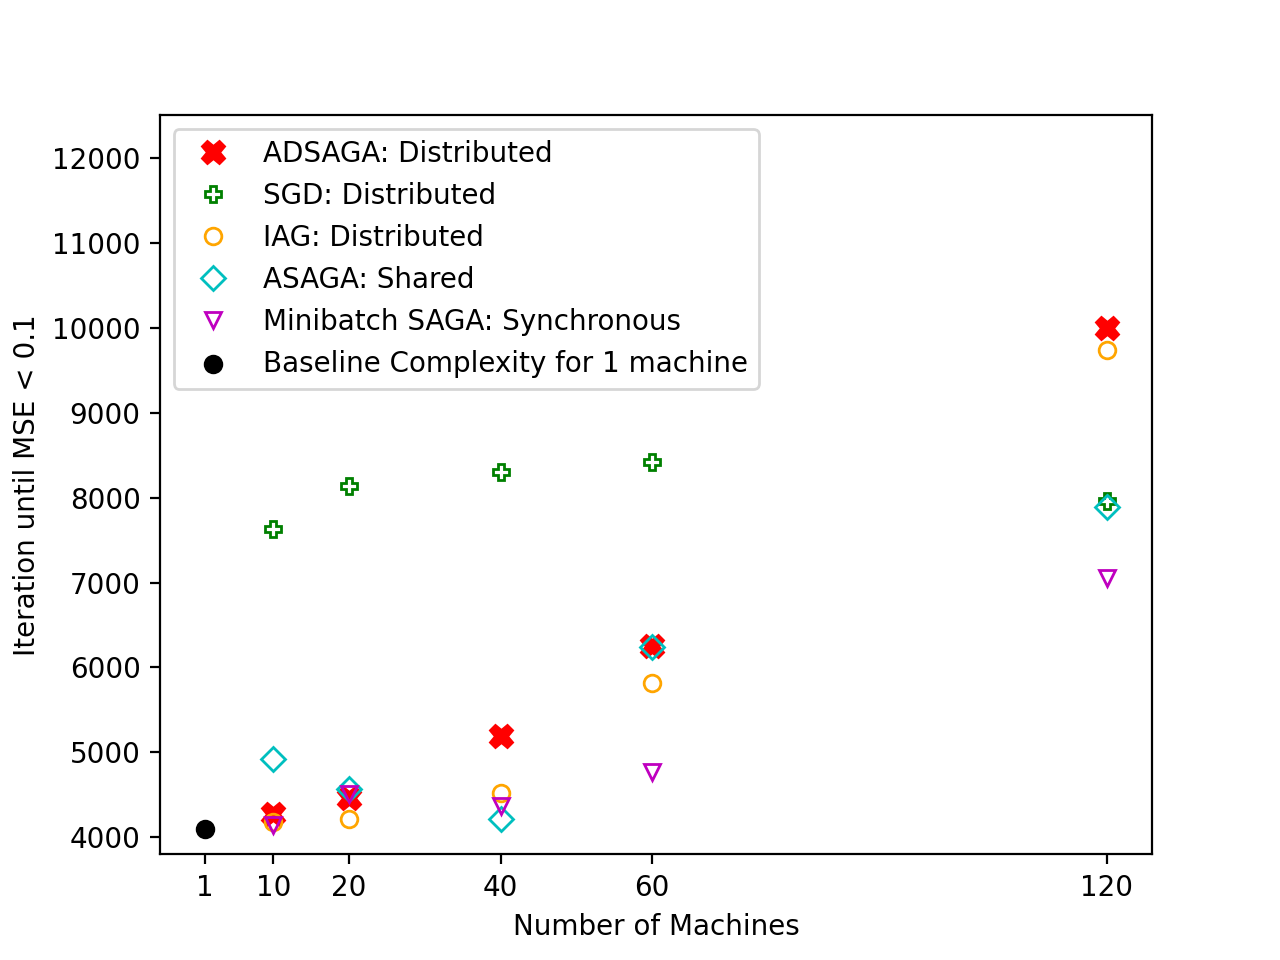

(3800.0, 12500.0)

In [21]:
num_results = results_reshape
mb = [4144.5,4513,4370.625,4765,7051]
%matplotlib notebook
import itertools
print(num_results)
marker = itertools.cycle(('X', 'P', 'o', 'D', 'v', '>' )) 
colors = itertools.cycle(('r', 'g', 'orange', 'c', 'm', 'y', 'k'))

xs = [10, 20, 40, 60, 120]
shifts = [0, 0.1, 1, 10]
# plt.hlines(4100, 0, 130, colors='k', linestyles='solid', label='Baseline Complexity for 1 machine')
for i in range(len(shifts)):
    values_d = num_results[i].T[0]
    values_c = num_results[i].T[1]
    values_sgd = num_results[i].T[2]
    values_iag = num_results[i].T[3]
#     m=next(marker)
#     c=next(colors)
    if shifts[i] == 10:
        c=next(colors)
        m = next(marker)
        plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='ADSAGA: Distributed', markersize=8)
        c=next(colors)
        m = next(marker)
        plt.plot(xs, values_sgd, marker=m, fillstyle='none', linestyle='None', color=c, label='SGD: Distributed')
        c=next(colors)
        m = next(marker)
        plt.plot(xs, values_iag, marker=m, fillstyle='none', linestyle='None', color=c, label='IAG: Distributed')
        c=next(colors)
        m = next(marker)
        plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shared')
c=next(colors)
m = next(marker)
plt.scatter([1], [4100], c='k', label='Baseline Complexity for 1 machine')
plt.plot(xs, mb, marker=m, fillstyle='none', linestyle='None', color=c, label='Minibatch SAGA: Synchronous')

plt.xlabel("Number of Machines")
plt.ylabel("Iteration until MSE < 0.1")
plt.legend(loc='upper left')
plt.xticks([1] + xs)
plt.ylim((3800, 12500))

In [34]:
num_results = results_reshape
mb = [4144.5,4513,4370.625,4765,7051]
%matplotlib notebook
import itertools
print(num_results)
marker = itertools.cycle(('o', 'P', 'X', 'D', 'v', '>' )) 
colors = itertools.cycle(('orange', 'g', 'r', 'c', 'm', 'y', 'k'))

xs = [10, 20, 40, 60, 120]
shifts = [0, 0.1, 1, 10]
c=next(colors)
m = next(marker)
# plt.hlines(4100, 0, 130, colors='k', linestyles='solid', label='Baseline Complexity for 1 machine')
plt.scatter([1], [4100], c='k', label='Baseline Complexity for 1 machine')
# plt.plot(xs, mb, marker=m, fillstyle='full', linestyle='None', color=c, label='Minibatch SAGA')
for i in range(len(shifts)):
    values_d = num_results[i].T[0]
    values_c = num_results[i].T[1]
    values_sgd = num_results[i].T[2]
    values_iag = num_results[i].T[3]
#     m=next(marker)
#     c=next(colors)
    if shifts[i] == -1:
        plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='Minibatch SAGA')
        #plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])
    else:
        c=next(colors)
        m = next(marker)
        plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='ADSAGA: Shift: %s' % shifts[i])
#         c=next(colors)
#         m = next(marker)
        plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])
#         c=next(colors)
#         m = next(marker)
#         plt.plot(xs, values_sgd, marker=m, fillstyle='full', linestyle='None', color=c, label='SGD: Shift: %s' % shifts[i])
#         c=next(colors)
#         m = next(marker)
#         plt.plot(xs, values_iag, marker=m, fillstyle='full', linestyle='None', color=c, label='IAG: Shift: %s' % shifts[i])

# plt.plot(xs, [1/(np.sqrt(x)) for x in xs], ls='dashed', label="$1/\sqrt{m}$")
# plt.plot(xs, [1/x for x in xs], ls='dashed', label="$1/m$")
plt.xlabel("Number of Machines")
plt.ylabel("Iteration until MSE < 0.1")
plt.legend(loc='upper left')
plt.xticks([1] + xs)
plt.ylim((3800, 10500))

[[[ 4538.625  4401.25   7073.     4166.5  ]
  [ 4313.5    4811.75   9098.     4629.25 ]
  [ 4934.125  5147.75   7436.625  5055.125]
  [ 5310.375  5042.375  9063.625  5695.75 ]
  [ 6224.625  6020.     9304.75   8918.875]]

 [[ 4390.375  4163.875  7273.25   4177.625]
  [ 4326.625  4556.875  7445.375  4265.625]
  [ 4699.875  4887.5    7985.375  5114.75 ]
  [ 5225.875  4739.25   8391.875  5965.625]
  [ 6362.75   6086.375  8179.75   8486.75 ]]

 [[ 4059.625  4342.     7823.25   4110.25 ]
  [ 4370.875  4433.     8382.75   4342.875]
  [ 5225.     5205.75   7166.75   5302.25 ]
  [ 5579.625  5501.125  8681.25   5456.5  ]
  [ 8684.     7067.25   8642.75   8800.5  ]]

 [[ 4275.5    4920.     7628.625  4177.25 ]
  [ 4463.375  4566.75   8139.25   4220.625]
  [ 5195.75   4215.25   8295.5    4518.125]
  [ 6253.     6239.625  8414.625  5820.375]
  [10000.     7893.625  7957.625  9739.625]]]


<IPython.core.display.Javascript object>

(3800.0, 10500.0)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


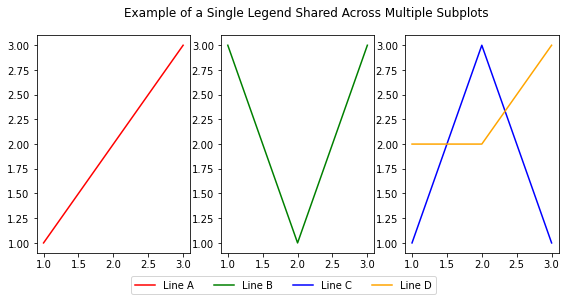

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
fig.suptitle('Example of a Single Legend Shared Across Multiple Subplots')

# The data
x =  [1, 2, 3]
y1 = [1, 2, 3]
y2 = [3, 1, 3]
y3 = [1, 3, 1]
y4 = [2, 2, 3]

# Labels to use in the legend for each line
line_labels = ["Line A", "Line B", "Line C", "Line D"]

# Create the sub-plots, assigning a different color for each line.
# Also store the line objects created
l1 = ax1.plot(x, y1, color="red")[0]
l2 = ax2.plot(x, y2, color="green")[0]
l3 = ax3.plot(x, y3, color="blue")[0]
l4 = ax3.plot(x, y4, color="orange")[0] # A second line in the third subplot

# Create the legend
fig.legend([l1, l2, l3, l4],     # The line objects
           labels=line_labels,   # The labels for each line
           loc="lower center",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
#            title="Legend Title"  # Title for the legend
           ncol = 4
           )

# Adjust the scaling factor to fit your legend text completely outside the plot
# (smaller value results in more space being made for the legend)
plt.subplots_adjust(right=0.85)

plt.show()

(1000, 1)


<IPython.core.display.Javascript object>


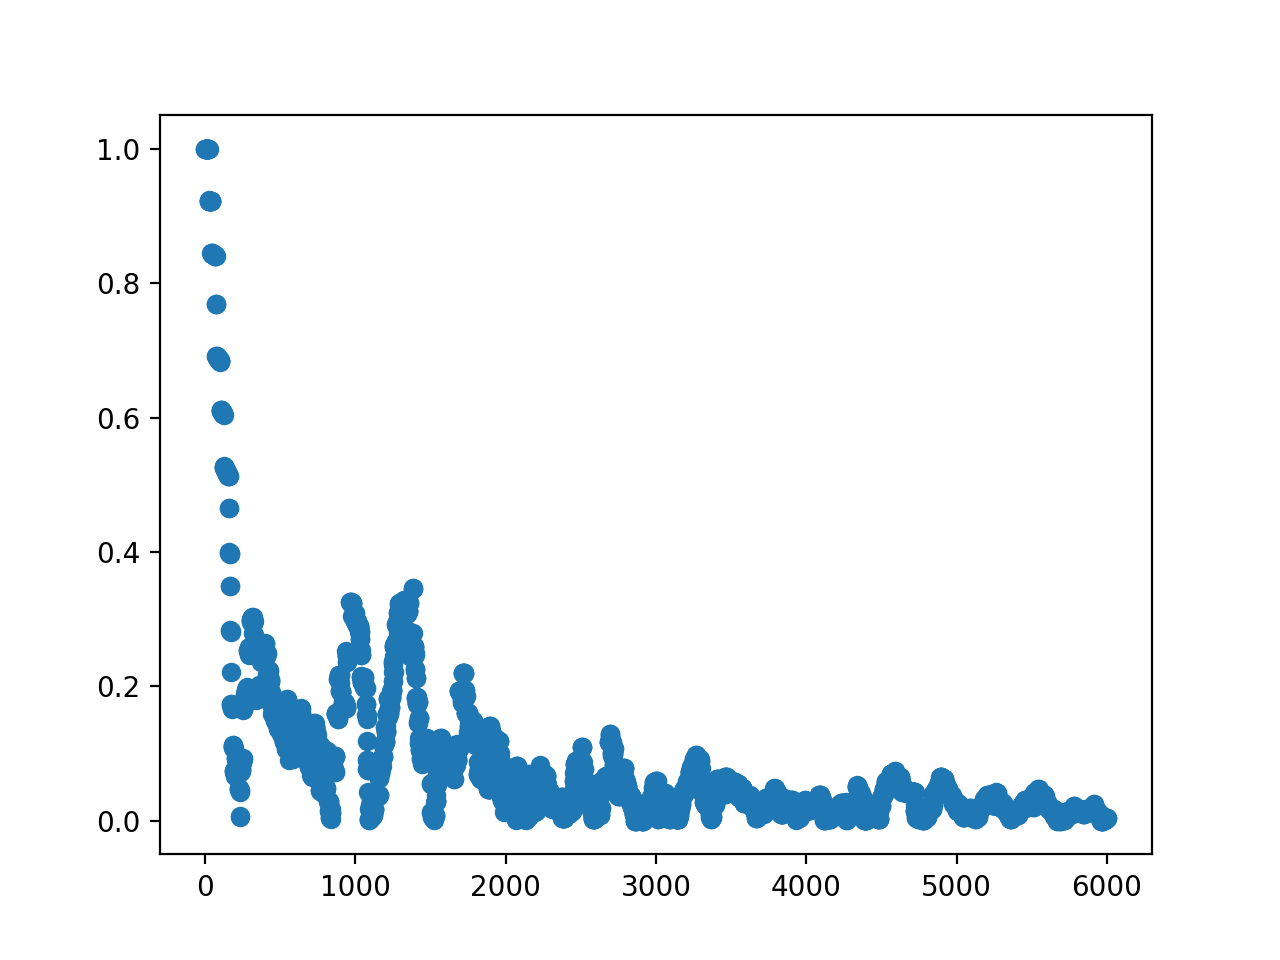

In [38]:
%matplotlib notebook
n = 1000
m = 200
Lf = 0.2
s = int(n*Lf)
A = np.array([np.concatenate((np.ones(s), np.zeros(n - s)))]).T
b = np.zeros(n)
x_0 = np.array([1])
eta = (1/13)
print(np.shape(A))
SE, bool = ASAGA_least_squares(A, b, m, eta, shifted_exp(0, 1), x_0, 6000)
plt.scatter(range(len(SE)), SE)

In [11]:
np.concatenate((np.ones(10), np.zeros(20)))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
res_ADSAGA_shift = []
res_IAG_shift = []
for shift in [-1, 0.5, 1, 5, 10]:
    for m in [30]:
        n = int(120/m)*m
        print(shift, m)
        res_ADSAGA_shift.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=8000, reps=4, shift=shift, block=1, IAG=True))
        res_ADSAGA_shift.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=8000, reps=4, shift=shift, block=1))

-1 30
[0.006, 4962.75, 621.8658918930994, 0]
[0.007, 4560.75, 319.8057027321433, 0]
0.5 30
[0.007, 4655.5, 336.31644324950867, 0]
[0.006, 5015.5, 1497.4696157184626, 0]
1 30
[0.005, 4917.25, 706.2522123859153, 0]
[0.006, 5105.75, 874.7126313824443, 0]
5 30
[0.007, 4157.25, 289.1862505376077, 0]
[0.007, 4916.25, 904.0095063106361, 0]
10 30
[0.007, 4379.0, 398.6157297448258, 0]
[0.007, 5060.0, 369.92026167810815, 0]


In [16]:
res_ADSAGA_shift_60 = []
res_IAG_shift_60 = []
for shift in [-1, 0.5, 1, 5, 10]:
    for m in [60]:
        n = int(120/m)*m
        print(shift, m)
        res_IAG_shift_60.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=8000, reps=4, shift=shift, block=1, IAG=True))
        res_ADSAGA_shift_60.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=8000, reps=4, shift=shift, block=1))

-1 60
[0.006, 4443.0, 357.9113018612293, 0]
[0.006, 5196.5, 917.0467545332681, 0]
0.5 60
[0.005, 6361.5, 596.0815799871692, 0]
[0.005, 5289.75, 269.2390898439526, 0]
1 60
[0.005, 5663.5, 544.1095937400847, 0]
[0.005, 6114.75, 471.75172230740185, 0]
5 60
[0.005, 5970.0, 855.7379856007328, 0]
[0.005, 6682.75, 806.9948497357341, 1]
10 60
[0.004, 5666.75, 386.440406143043, 0]
[0.005, 6679.5, 651.7950214599679, 0]


In [17]:
res_ADSAGA_shift_120 = []
res_IAG_shift_120 = []
for shift in [-1, 0.5, 1, 5, 10]:
    for m in [120]:
        n = int(120/m)*m
        print(shift, m)
        res_IAG_shift_120.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=8000, reps=4, shift=shift, block=1, IAG=True))
        res_ADSAGA_shift_120.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(1, 20)],1.0, 0.1, max_its=8000, reps=4, shift=shift, block=1))

-1 120
[0.005, 6563.0, 202.82874549727907, 0]
[0.004, 7038.0, 281.3876329905065, 0]
0.5 120
[0.003, 7990.0, 17.320508075688775, 3]
[0.004, 6696.25, 971.4196762985605, 1]
1 120
[0.003, 7949.0, 88.33459118601274, 3]
[0.004, 7421.75, 579.7276839171992, 2]
5 120
[0.001, 8000.0, 0.0, 4]
[0.001, 8000.0, 0.0, 4]
10 120
[0.001, 8000.0, 0.0, 4]
[0.001, 8000.0, 0.0, 4]


In [18]:
res_ADSAGA_shift = []
res_IAG_shift = []
for shift in [0, 0.5, 1, 5, 10]:
    for m in [60]:
        n = int(120/m)*m
        print(shift, m)
        res_IAG_shift.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(3, 9)],1.0, 0.1, max_its=8000, reps=8, shift=shift, block=1, IAG=True))
        res_ADSAGA_shift.append(grid_search_LS_desired_accuracy(n, m, int(n/2), [0.001*i for i in range(3, 9)],1.0, 0.1, max_its=8000, reps=8, shift=shift, block=1))

0 60
[0.005, 6208.875, 849.6255701042666, 0]
[0.006, 4932.125, 470.8474905688677, 0]
0.5 60
[0.005, 5574.75, 470.13874281960636, 0]
[0.005, 5227.875, 706.686712323785, 0]
1 60
[0.005, 6118.625, 508.31853632835384, 0]
[0.005, 5592.625, 1201.0783631283182, 0]
5 60
[0.005, 6158.5, 963.1204493727666, 0]
[0.005, 5563.75, 522.9172377154916, 0]
10 60
[0.005, 6527.5, 964.7604624983344, 1]
[0.005, 5722.875, 1038.9933153658883, 1]


<IPython.core.display.Javascript object>


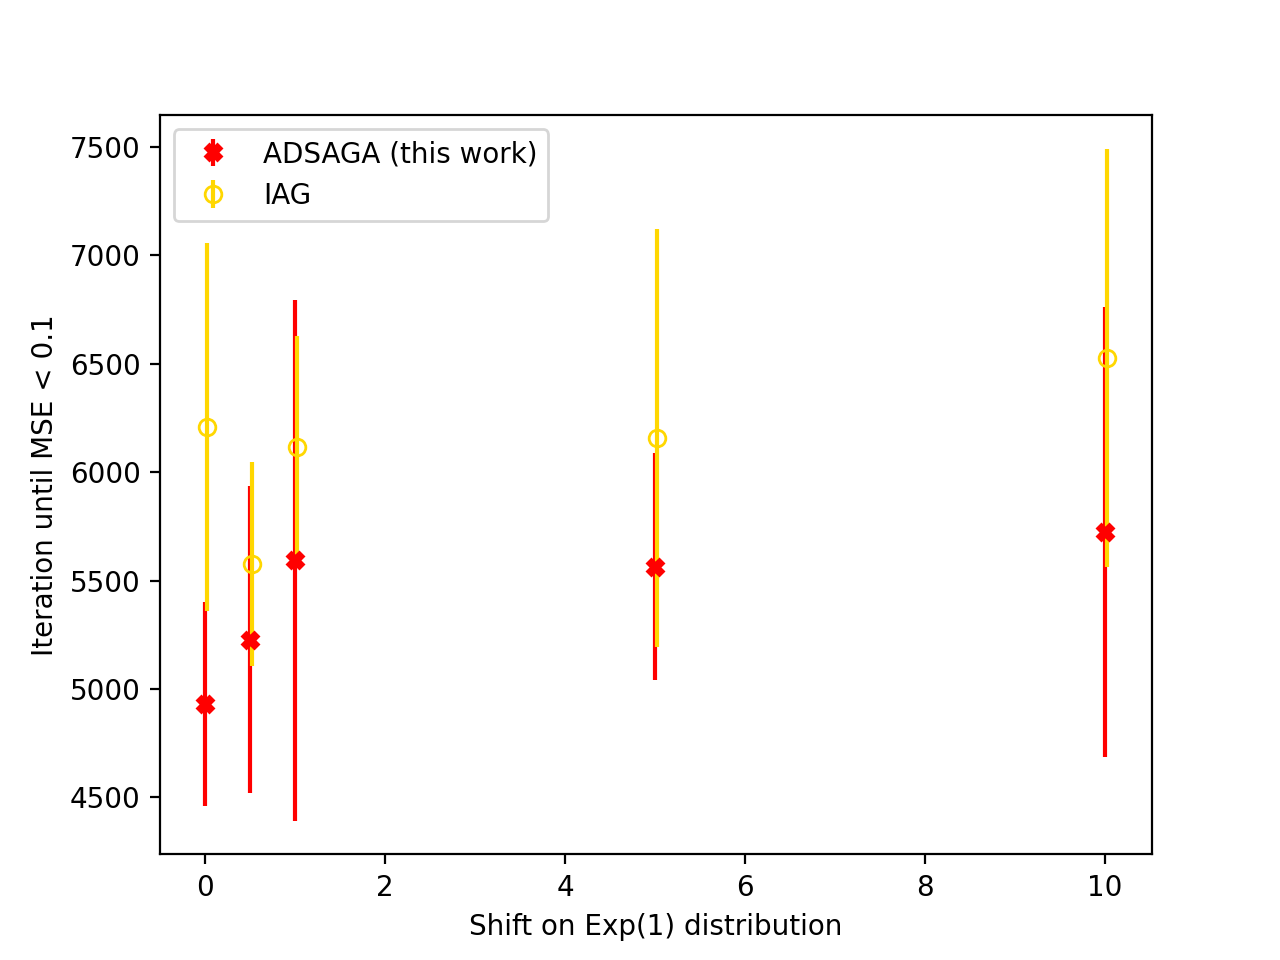

In [41]:
%matplotlib notebook
# marker = itertools.cycle(('o', 'P', 'X', 'D', 'v', '>' )) 
# colors = itertools.cycle(('orange', 'g', 'r', 'c', 'm', 'y', 'k'))
shifts = [0, 0.5, 1, 5, 10]
# c=next(colors)
# m = next(marker)

adsaga_res = np.array(res_ADSAGA_shift)
iag_res = np.array(res_IAG_shift)

plt.errorbar(shifts, adsaga_res.T[1], adsaga_res.T[2], marker='X', fillstyle='full', linestyle='None', color='r', label="ADSAGA (this work)")
plt.errorbar(np.array(shifts)+0.02, iag_res.T[1], iag_res.T[2], marker='o', fillstyle='none', linestyle='None', color='gold',  label="IAG")

# for i in range(len(shifts)):
#     values_d = num_results[i].T[0]
#     values_c = num_results[i].T[1]
#     values_sgd = num_results[i].T[2]
#     values_iag = num_results[i].T[3]
# #     m=next(marker)
# #     c=next(colors)
#     if shifts[i] == -1:
#         plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='Minibatch SAGA')
#         #plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])
#     else:
#         c=next(colors)
#         m = next(marker)
#         plt.plot(xs, values_d, marker=m, fillstyle='full', linestyle='None', color=c, label='ADSAGA: Shift: %s' % shifts[i])
# #         c=next(colors)
# #         m = next(marker)
#         plt.plot(xs, values_c, marker=m, fillstyle='none', linestyle='None', color=c, label='ASAGA: Shift: %s' % shifts[i])
# #         c=next(colors)
# #         m = next(marker)
# #         plt.plot(xs, values_sgd, marker=m, fillstyle='full', linestyle='None', color=c, label='SGD: Shift: %s' % shifts[i])
# #         c=next(colors)
# #         m = next(marker)
# #         plt.plot(xs, values_iag, marker=m, fillstyle='full', linestyle='None', color=c, label='IAG: Shift: %s' % shifts[i])

# # plt.plot(xs, [1/(np.sqrt(x)) for x in xs], ls='dashed', label="$1/\sqrt{m}$")
# # plt.plot(xs, [1/x for x in xs], ls='dashed', label="$1/m$")


plt.xlabel("Shift on Exp(1) distribution")
plt.ylabel("Iteration until MSE < 0.1")
plt.legend(loc='upper left')
# plt.xticks(shifts)
# plt.ylim((0, 8000))